Purpose of Code
1. Import necessary packages
2. Define class Image for the "image" files
3. Define class Nuclei for the "nuclei" files
4. Create an xlsx worksheet with multiple sheets
5. Include relevant values for all sheets

In [67]:
# RUN THIS FIRST
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import openpyxl
import xlrd
import math
import statistics as stats
import os 
import csv 
import xlsxwriter
import matplotlib.ticker as ticker
from matplotlib_venn import venn3
from matplotlib_venn import venn2, venn2_circles
from io import StringIO
from scipy import stats
#!pip install matplotlib-venn (if you have not yet installed matplotlib-venn, install it!)

In [68]:
##### create class Image to store information of channels, area_occupied, 
##### area_occupied_total, and file_name
class Image:
    def __init__(self, image_file_name): ## takes in the image_file name
        self.image_file_name = image_file_name 
        self.channels = {} # populates self channels with channels found in file
        self.total_occupied = None
    
    def add_channel(self, new_channel, area_occupied):
        self.channels[new_channel] = area_occupied
        
    def set_total_occupied(self,total_occupied):
        self.total_occupied = total_occupied
        
    def find_channel_percent(self): ## calculates percentage from area occupied
        if self.total_occupied:
            channel_percent = {} #open a dictionary
            for channel in self.channels:
                channel_percent[channel] = self.channels[channel]/self.total_occupied*100
            return channel_percent
        return None

In [69]:
class Nuclei:
    def __init__(self, nuclei_file_name):
        self.nuclei_file_name = nuclei_file_name 
        self.channels = {}
        self.total_nuclei = None
    
    def add_channel(self, new_channel, nuclei_value):
        self.channels[new_channel] = nuclei_value ### nuclei value is "logical vector"
        
    def set_total_occupied(self,total_nuclei):
        self.total_nuclei = total_nuclei ## total nuclei in this image
                   
    def find_sum_value(self):
        if self.channels:
            channel_sum = {} ## this is a dictionary of the sum of the logical vector per channel
            for channel in self.channels: 
                channel_sum[channel] = sum(self.channels[channel])
            return channel_sum
    
    def find_channel_percent(self): ## calculates percentage from nuclei/total
        if self.total_nuclei:
            channel_percent = {}
            for channel in self.channels:
                channel_percent[channel] = sum(self.channels[channel])/self.total_nuclei*100
            return channel_percent
      
    def find_col(self): 
        if self.channels: 
            nuclei_col = {}
            if len(self.channels) == 2: 
                for i in self.channels: 
                    for j in self.channels:
                        nuclei_col[i+'+'+j] = np.dot(self.channels[i], self.channels[j])
            return nuclei_col

In [70]:
#### FIND AREA OCCUPIED AND NUCLEI #####

# Create a new excel file to store information
# processed_files_areas is where areas information will be stored
workbook = xlsxwriter.Workbook('ASt_area_occupied_nuclei_colocalization.xlsx')
# make sheets
sheet1 = workbook.add_worksheet('Area_Occupied')
sheet2 = workbook.add_worksheet('Area_Occupied_Total')
sheet3 = workbook.add_worksheet('Nuclei')
sheet4 = workbook.add_worksheet('Nuclei_Total')
sheet5 = workbook.add_worksheet('Colocalization')
sheets = [sheet1, sheet2, sheet3, sheet4, sheet5]

# polulate sheet with channel/region value labels
labels = [['DRD1', 'ASt'], 
          ['DRD1', 'DS'], 
          ['DRD1', 'TS'], 
          ['DRD1', 'TS-Med'], 
          ['DRD1', 'TS-Lat'], 
          ['DRD2', 'ASt'], 
          ['DRD2', 'DS'], 
          ['DRD2', 'TS'], 
          ['DRD2', 'TS-Med'], 
          ['DRD2', 'TS-Lat']]

##### LOOP THROUGH CSV FILES HERE

#### rows and clumns are zero indexed
### worksheet.write(row, col, some_data) is how you add information to the xlsx file
for worksheet in sheets: 
    row = 1
    col = 0
    for channel, region in labels: # add the labels
        worksheet.write(row, col, channel)
        worksheet.write(row, col +1, region)
        row += 1

#labels_colocalization 
labels_col = [['DRD1+DRD2', 'ASt'], 
          ['DRD1+DRD2', 'DS'], 
          ['DRD1+DRD2', 'TS'], 
          ['DRD1+DRD2', 'TS-Med'], 
          ['DRD1+DRD2', 'TS-Lat']]

# add remaining colocalization labels to sheet5
col = 0
for channel, region in labels_col: # add the labels
    sheet5.write(row, col, channel)
    sheet5.write(row, col +1, region)
    row += 1

######################### labels are inserted into the worksheet, now we can add data

##################### USE images files to calculate AREA OCCUPIED ##########################

#loop through csv files for IMAGES
images = [] # create empty list of images
## sort through folder, open a file in the folder
for file_name in sorted(os.listdir('ASt_cell_profiler_outputs')): 
    with open('ASt_cell_profiler_outputs/'+file_name) as file:
        if 'Image' in file_name: ## only take out files that have area_occupied
            image = Image(file_name) ##using the class now to set file name
            pd.read_csv('ASt_cell_profiler_outputs/'+file_name, delimiter = ',')
            data_frame = pd.read_csv('ASt_cell_profiler_outputs/'+file_name)
            image.set_total_occupied(data_frame.iloc[0,0]) #total occupied is first number
            headers = list(data_frame.columns)
            col = 0
            for header in headers: ## find channel names from header names
                if 'AreaOccupied_AreaOccupied_RelateNuc'in header:
                    channel = header.replace('AreaOccupied_AreaOccupied_RelateNuc','')
                    value = data_frame.iloc[0,col] ## get value for that channel
                    image.add_channel(channel,value) ## 
                col += 1 
            ## add this image to the list
            images.append(image)

#start columns after the labels
slice_col = 2           
for image in images:
    ## find the AP value from the file_Name
    AP_value = image.image_file_name.split('stack_')[1].replace('_Image.csv','')
    sheet1.write(0, slice_col, image.image_file_name)
    sheet2.write(0, slice_col, image.image_file_name)
    # for each channel the row  is where the channel and AP value match
    for channel in image.channels: 
        row = (labels.index([channel, AP_value]))+1
        sheet1.write(row, slice_col, image.channels[channel])
        sheet2.write(row, slice_col, image.find_channel_percent()[channel])  
    slice_col+= 1

####### PROCESS NUCLEI #######

nucleis = [] # create empty list of images
for file_name in sorted(os.listdir('ASt_cell_profiler_outputs')): 
    with open('ASt_cell_profiler_outputs/'+file_name) as file:
        if 'NucleiAllExp' in file_name: ## only take out files that have nuclei
            nuclei = Nuclei(file_name) # set file name 
            data_frame = pd.read_csv('ASt_cell_profiler_outputs/'+file_name)
            headers = list(data_frame.columns)
            total_nuclei = len(data_frame.iloc[:,1])
            nuclei.set_total_occupied(total_nuclei)
            col = 0
            for header in headers: ## find channel names from header names
                if 'Children_All'in header:
                    channel = header.split('All')[1].replace('_Count', '')
                    nuclei_full = data_frame.iloc[:,col]
                    greater_than_2 = []
                    for nuc in nuclei_full: 
                        if nuc >2: 
                            greater_than_2.append(1)
                        else: 
                            greater_than_2.append(0)
                    nuclei_value = greater_than_2 ##list of nuclei > 2
                    nuclei.add_channel(channel,nuclei_value)
                col += 1 
            ## add this nuclei to the list
            nucleis.append(nuclei)
            
## start columns after the labels
slice_col = 2 
for nuclei in nucleis:
    ## find the region value from the file_Name
    region_value = nuclei.nuclei_file_name.split('stack_')[1].replace('_NucleiAllExp.csv','')
    ## add file_name as a header for that column
    sheet3.write(0, slice_col, nuclei.nuclei_file_name)
    sheet4.write(0, slice_col, nuclei.nuclei_file_name)
    sheet5.write(0, slice_col, nuclei.nuclei_file_name)
    sum_nuclei = nuclei.find_sum_value()
    combinations = nuclei.find_col()
    # for each channel the row  is where the channel and AP value match
    for channel in nuclei.channels: 
        row = (labels.index([channel, region_value]))+1
        sheet3.write(row, slice_col, sum_nuclei[channel])
        sheet4.write(row, slice_col, nuclei.find_channel_percent()[channel])    
        sheet5.write(row, slice_col, sum(nuclei.channels[channel]))
    for channel in combinations: 
        try:
            row = (labels_col.index([channel, region_value])+1+len(labels))
            sheet5.write(row, slice_col, combinations[channel])
        except ValueError: 
            continue 
    slice_col+= 1    


workbook.close()

In [71]:
### Find H-Score

# # Create a new excel file to store information
# # processed_files.xlsx is where information will be stored
workbook2 = xlsxwriter.Workbook('ASt_H_scores.xlsx')
# make sheets
worksheets = ['DRD1 ASt', 'DRD1 DS', 'DRD1 TS', 'DRD1 TS-Med', 
          'DRD1 TS-Lat', 'DRD2 ASt', 'DRD2 DS', 
          'DRD2 TS', 'DRD2 TS-Med', 'DRD2 TS-Lat']
sheets = []
for i in range(10):
    sheets.append(workbook2.add_worksheet(worksheets[i]))

####### PROCESS HSCORE #######

cols = {}
for file_name in sorted(os.listdir('ASt_cell_profiler_outputs')): 
    with open('ASt_cell_profiler_outputs/'+file_name) as file:
        if 'NucleiAllExp' in file_name: ## only take out files that have nuclei
            data_frame = pd.read_csv('ASt_cell_profiler_outputs/'+file_name)
            headers = list(data_frame.columns)
            col = 0
            for header in headers: ## find channel names from header names
                if 'Children_All'in header:
                    channel = header.split('All')[1].replace('_Count', '') ### this is channel name "DRD1"
                    region_value = file_name.split('stack_')[1].replace('_NucleiAllExp.csv','') ### region "ASt"
                    sheet_name = channel+' '+region_value ### name of sheet "DRD1 ASt"
                    nuclei_full = data_frame.iloc[:,col]
                    greater_than_0 = [] # make a list only of nuclei that have more than 0 children puncta
                    for nuc in nuclei_full: 
                        if nuclei_full[nuc] >0: 
                            greater_than_0.append(nuclei_full[nuc])
                    if sheet_name not in cols: # add a dictionary with sheet_name: counter for columns
                        cols[sheet_name] = 0
                    else: 
                        cols[sheet_name]+=1 
                    i = (worksheets.index(sheet_name))
                    sheets[i].write(0, cols[worksheets[i]], file_name) # add file name as header
                    for counter in range(len(greater_than_0)):  ## add values for all the nuclei children
                        sheets[i].write(counter+1, cols[worksheets[i]], greater_than_0[counter])
                col+=1
        print(file_name)

workbook2.close()

20200225_Lihai1_slide6_slice8_ASt_20x_stack_ASt_Image.csv
20200225_Lihai1_slide6_slice8_ASt_20x_stack_ASt_NucleiAllExp.csv
20200310_Lihai1_slide9_slice1_ASt_L_40x_stack_ASt_Image.csv
20200310_Lihai1_slide9_slice1_ASt_L_40x_stack_ASt_NucleiAllExp.csv
20200310_Lihai1_slide9_slice1_ASt_R_40x_stack_ASt_Image.csv
20200310_Lihai1_slide9_slice1_ASt_R_40x_stack_ASt_NucleiAllExp.csv
20200311_Lihai1_slide9_slice3_ASt_L_40x_stack_ASt_Image.csv
20200311_Lihai1_slide9_slice3_ASt_L_40x_stack_ASt_NucleiAllExp.csv


In [72]:
######### FUNCTION TO MAKE LINE GRAPHS OF TOTAL AREA OCCUPIED AND NUCLEI COUNTS ############

####import excel file from previous code
data_sheets_1 = "ASt_area_occupied_nuclei_colocalization.xlsx"

## function to sort through xlsx sheets, workbook defines the sheet name 
## m defines which means to plot, s defines which sems to plot, and c defines the color of the bars

def plot_one_graph(workbook, m, s, c):
    
    # read data from excel as pandas dataframe
    data_frame = pd.read_excel(data_sheets_1, sheet_name = workbook)

    # find mean/SD along axis=1(rows) NOT axis=0(columns) 
    APmeans = data_frame.iloc[0:,2:].mean(axis=1)
    APsem = data_frame.iloc[0:,2:].sem(axis=1)

    # create lists for bar heights and sems for each graph DRD1 and DRD2
    
    DRD1_means = []
    DRD2_means = []
    DRD1_sems = []
    DRD2_sems = []

    for i in range(len(APmeans)):
        APmeans[np.isnan(APmeans)] = 0
        APmeans[np.isnan(APmeans)] = 0
        if i < 5:
            DRD1_means.append(APmeans[i])   
        else:
            DRD2_means.append(APmeans[i])
    for j in range(len(APsem)):
        APsem[np.isnan(APsem)] = 0
        APsem[np.isnan(APsem)] = 0
        if j < 5:
            DRD1_sems.append(APsem[j])
        else:
            DRD2_sems.append(APsem[j])
    
    #### create bar chart for DRD1 data
    x = range(0,4)
    fig = plt.figure(dpi=150,figsize=(10,10))
    fig.add_subplot(111)
    labels = ("ASt", "DS", "TS", "TS-med", 'TS-lat')
    positions = (0, 1, 2, 3, 4)
    plt.xticks(positions, labels)
    #plt.ylim(0,150)
    plt.bar([0,1,2,3,4], m, yerr=s, width = 1, color = c) 
    plt.tight_layout()
    return fig

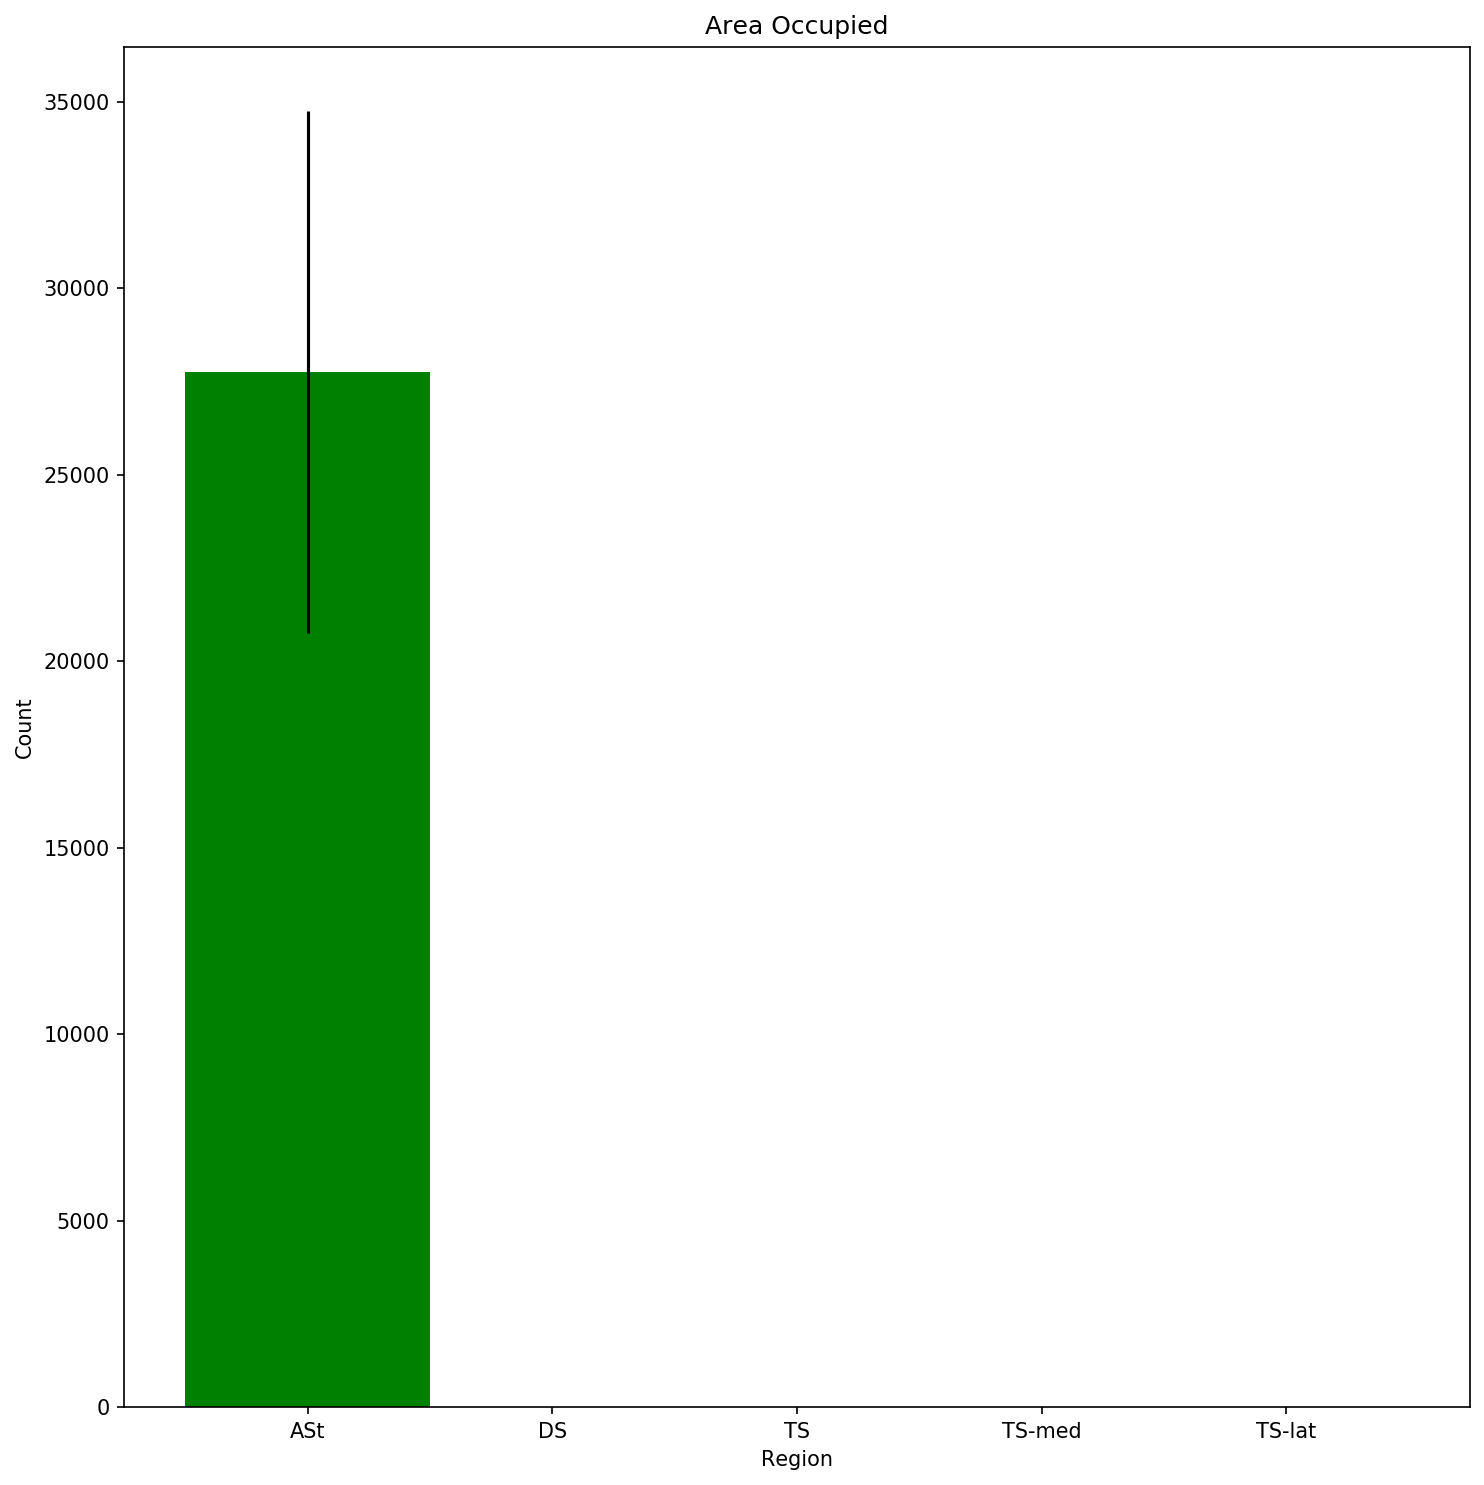

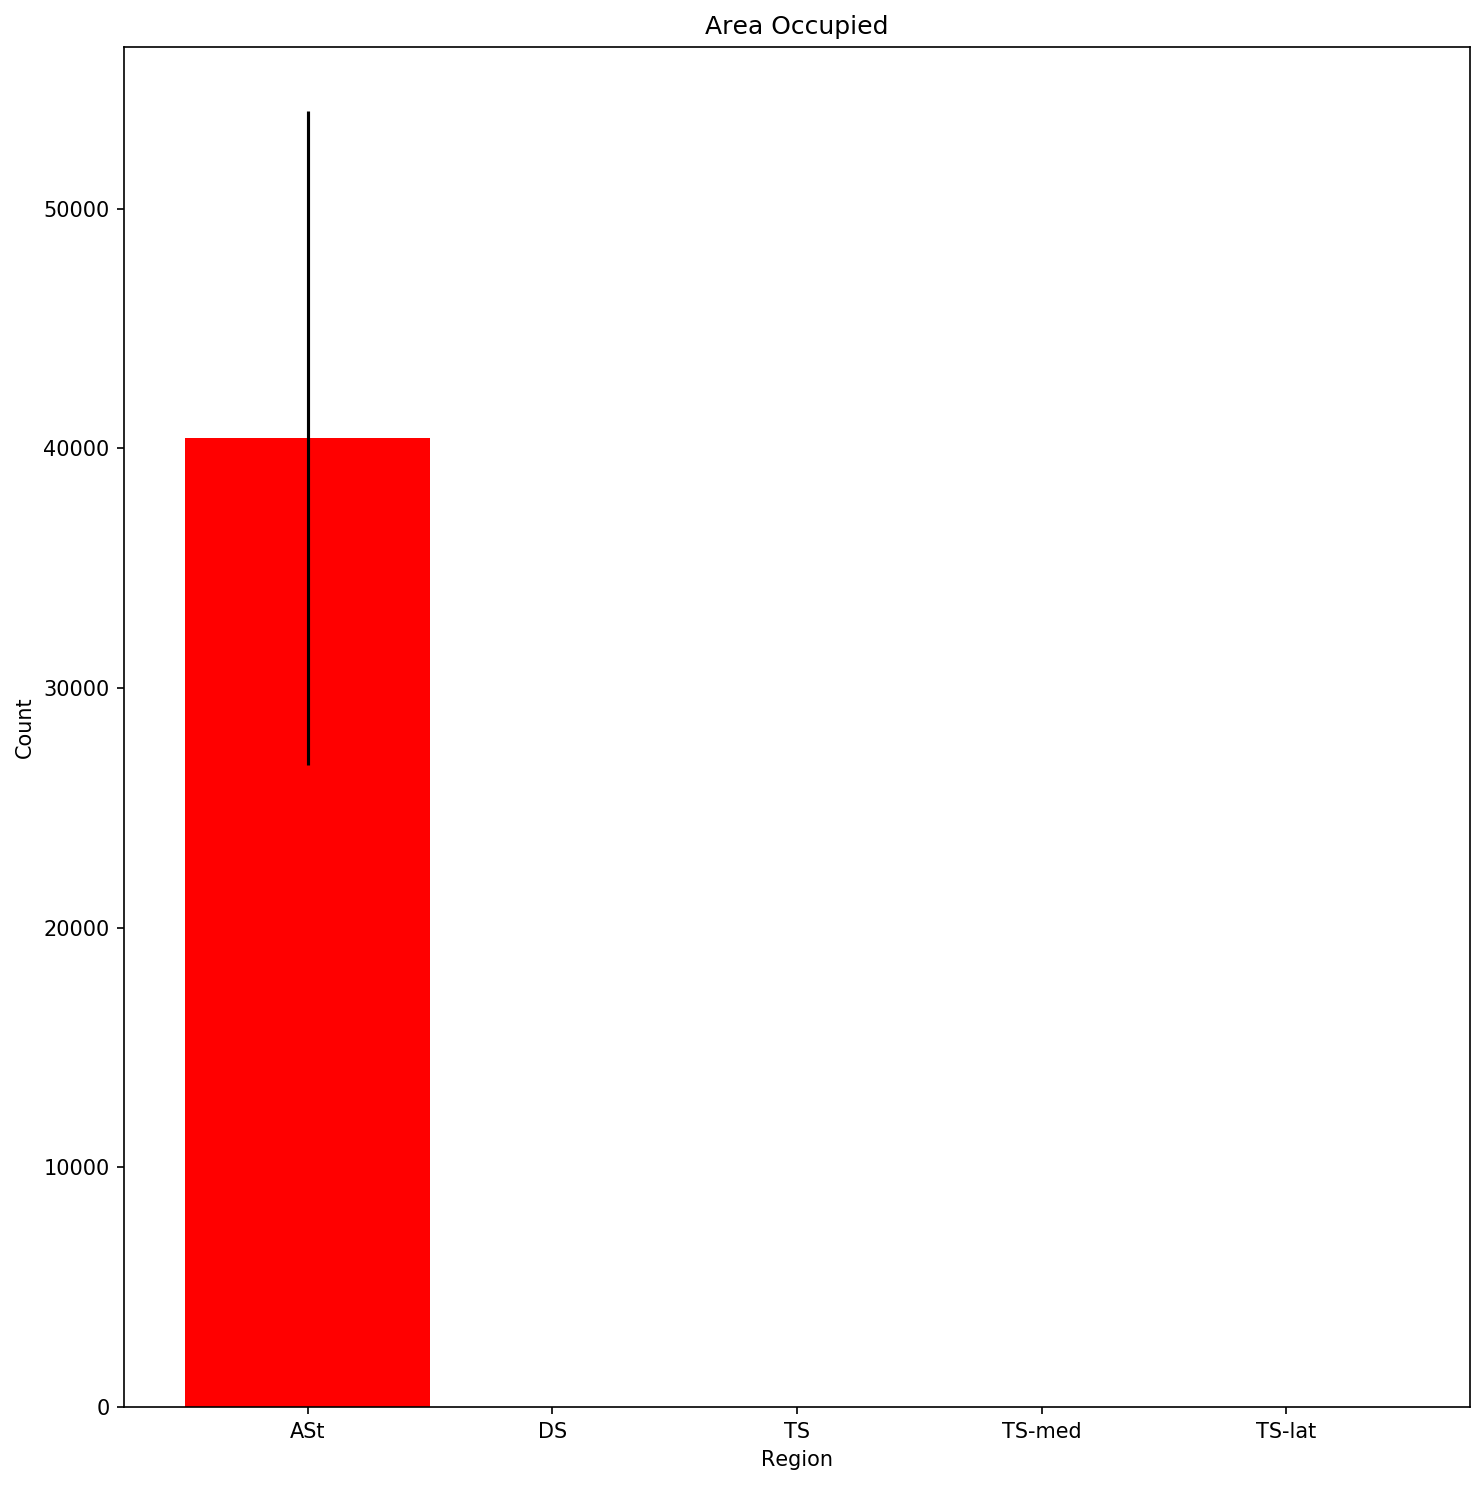

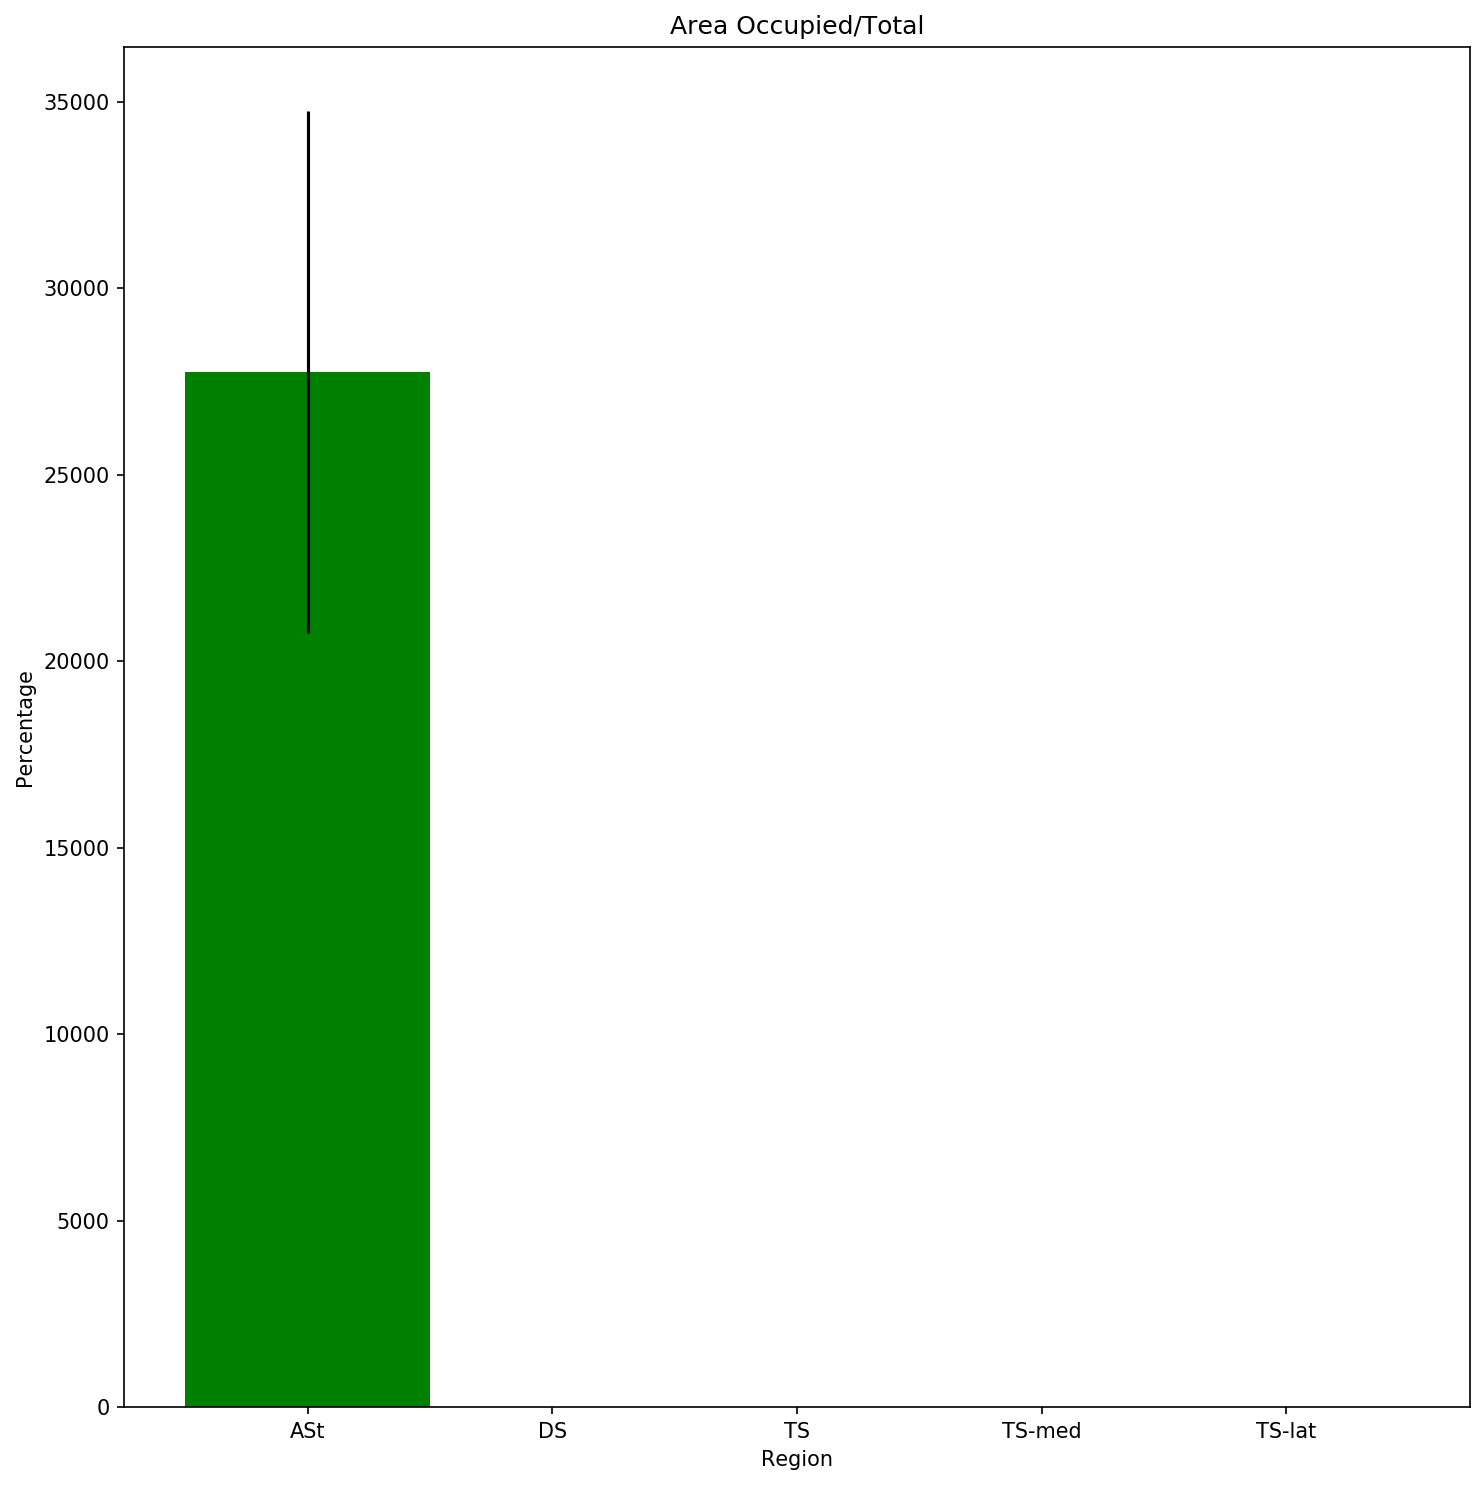

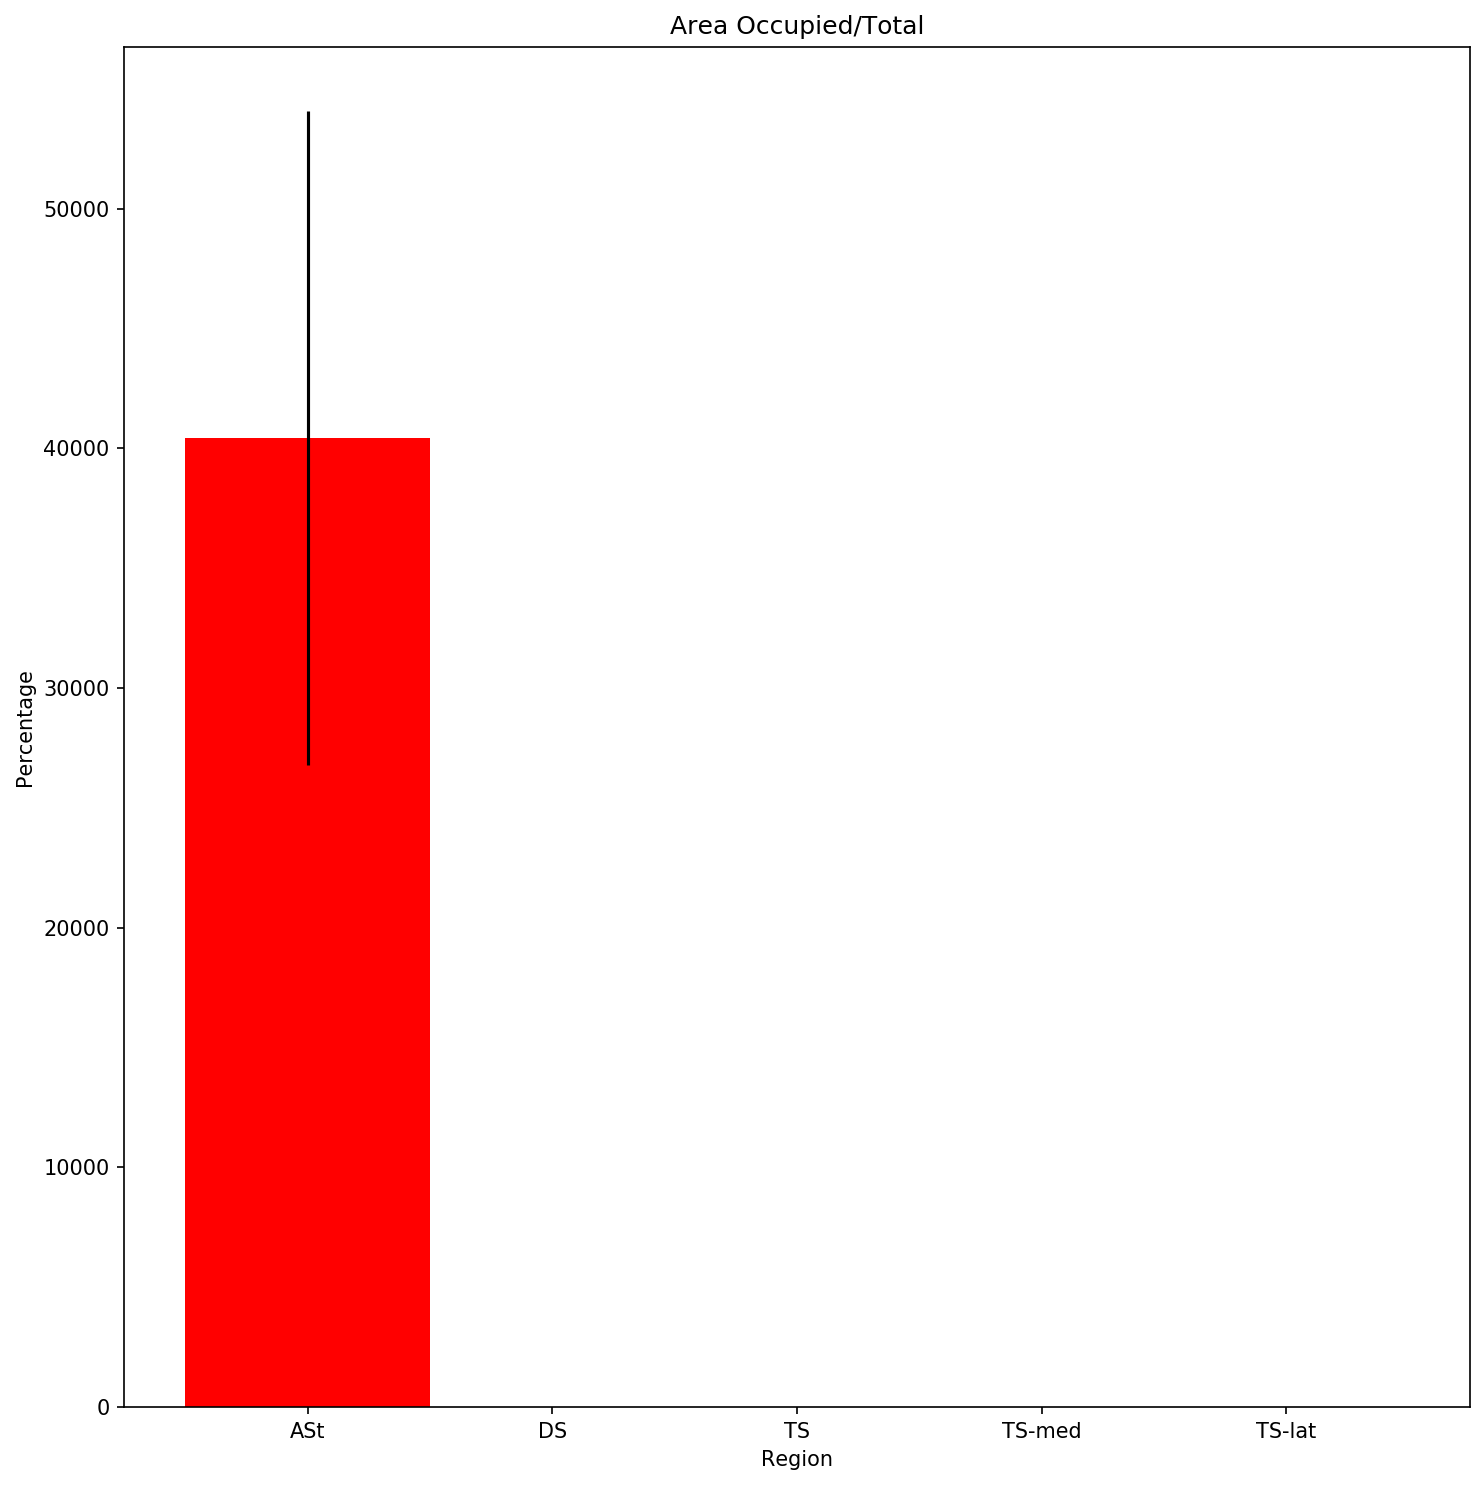

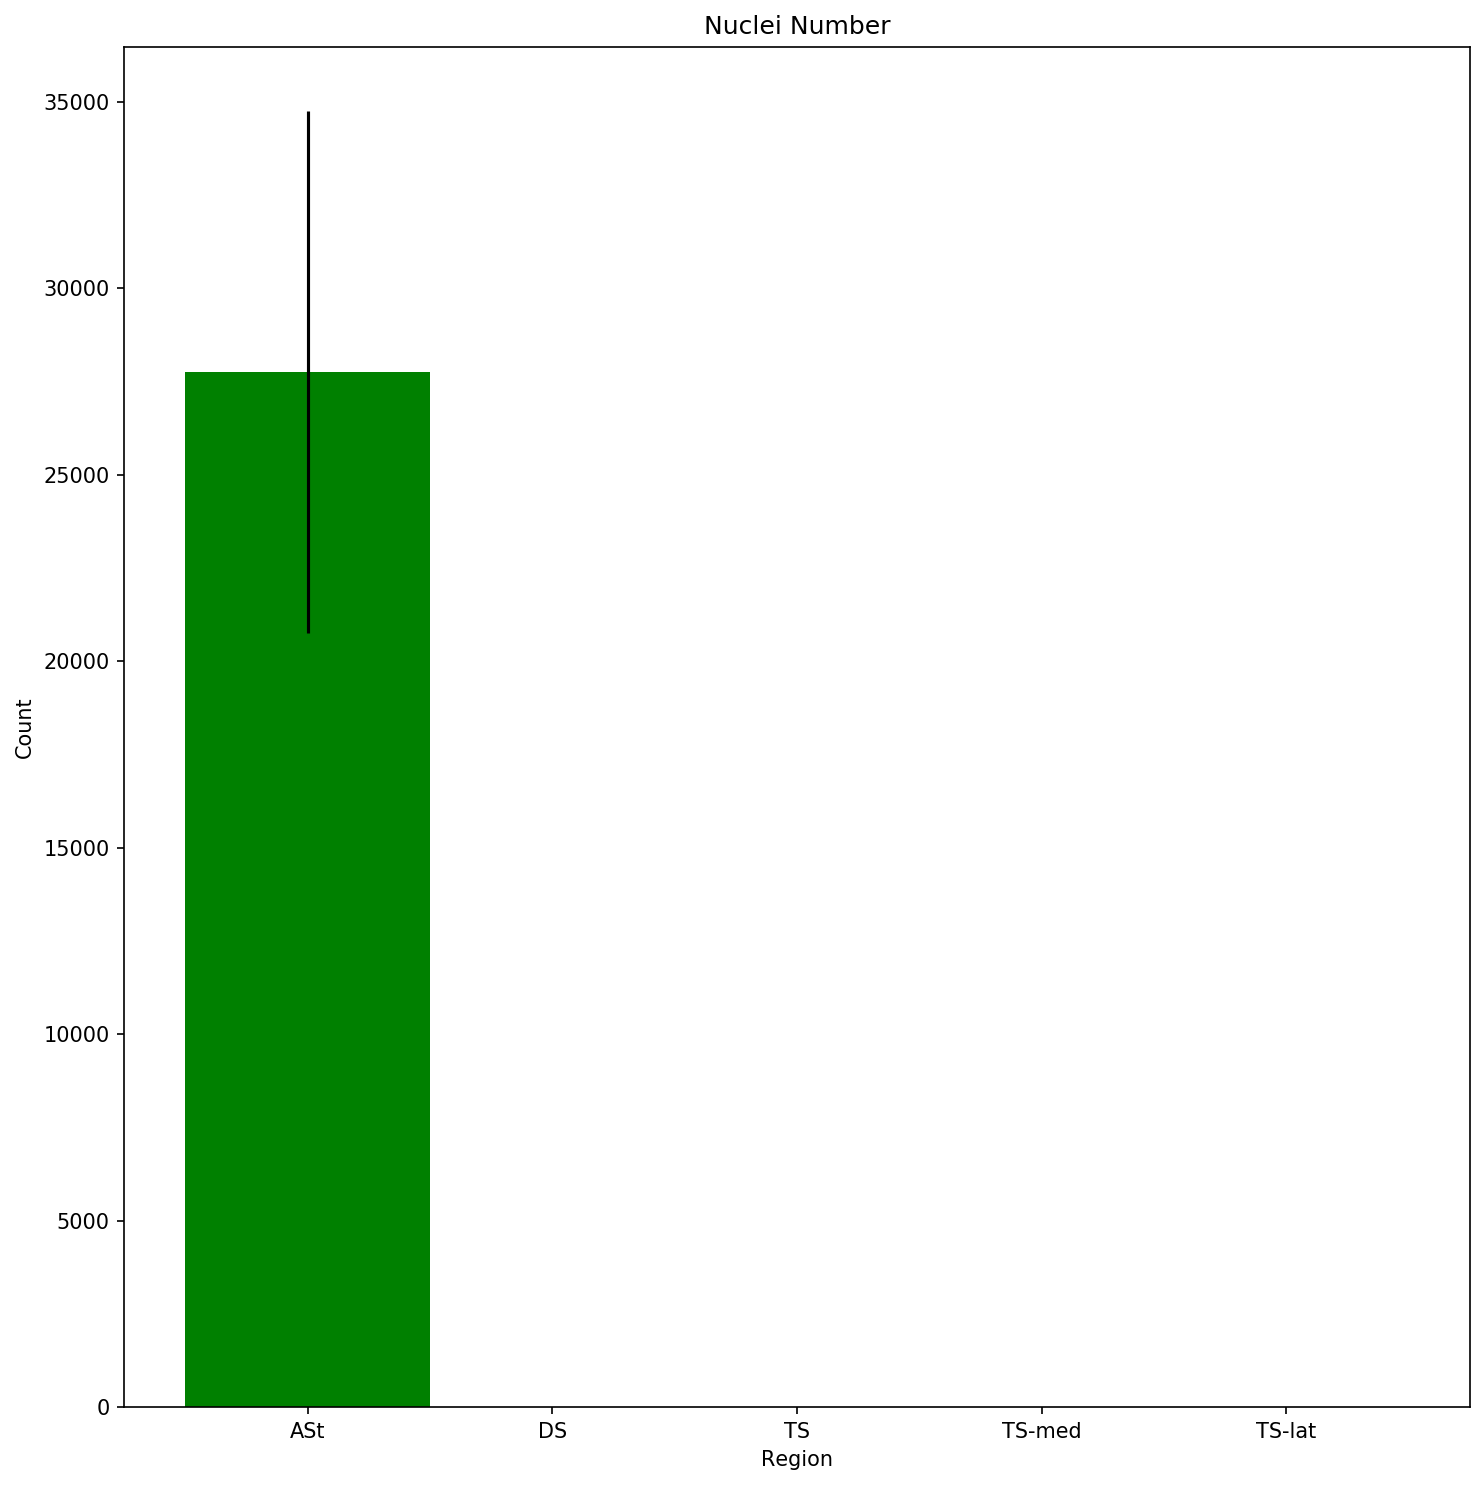

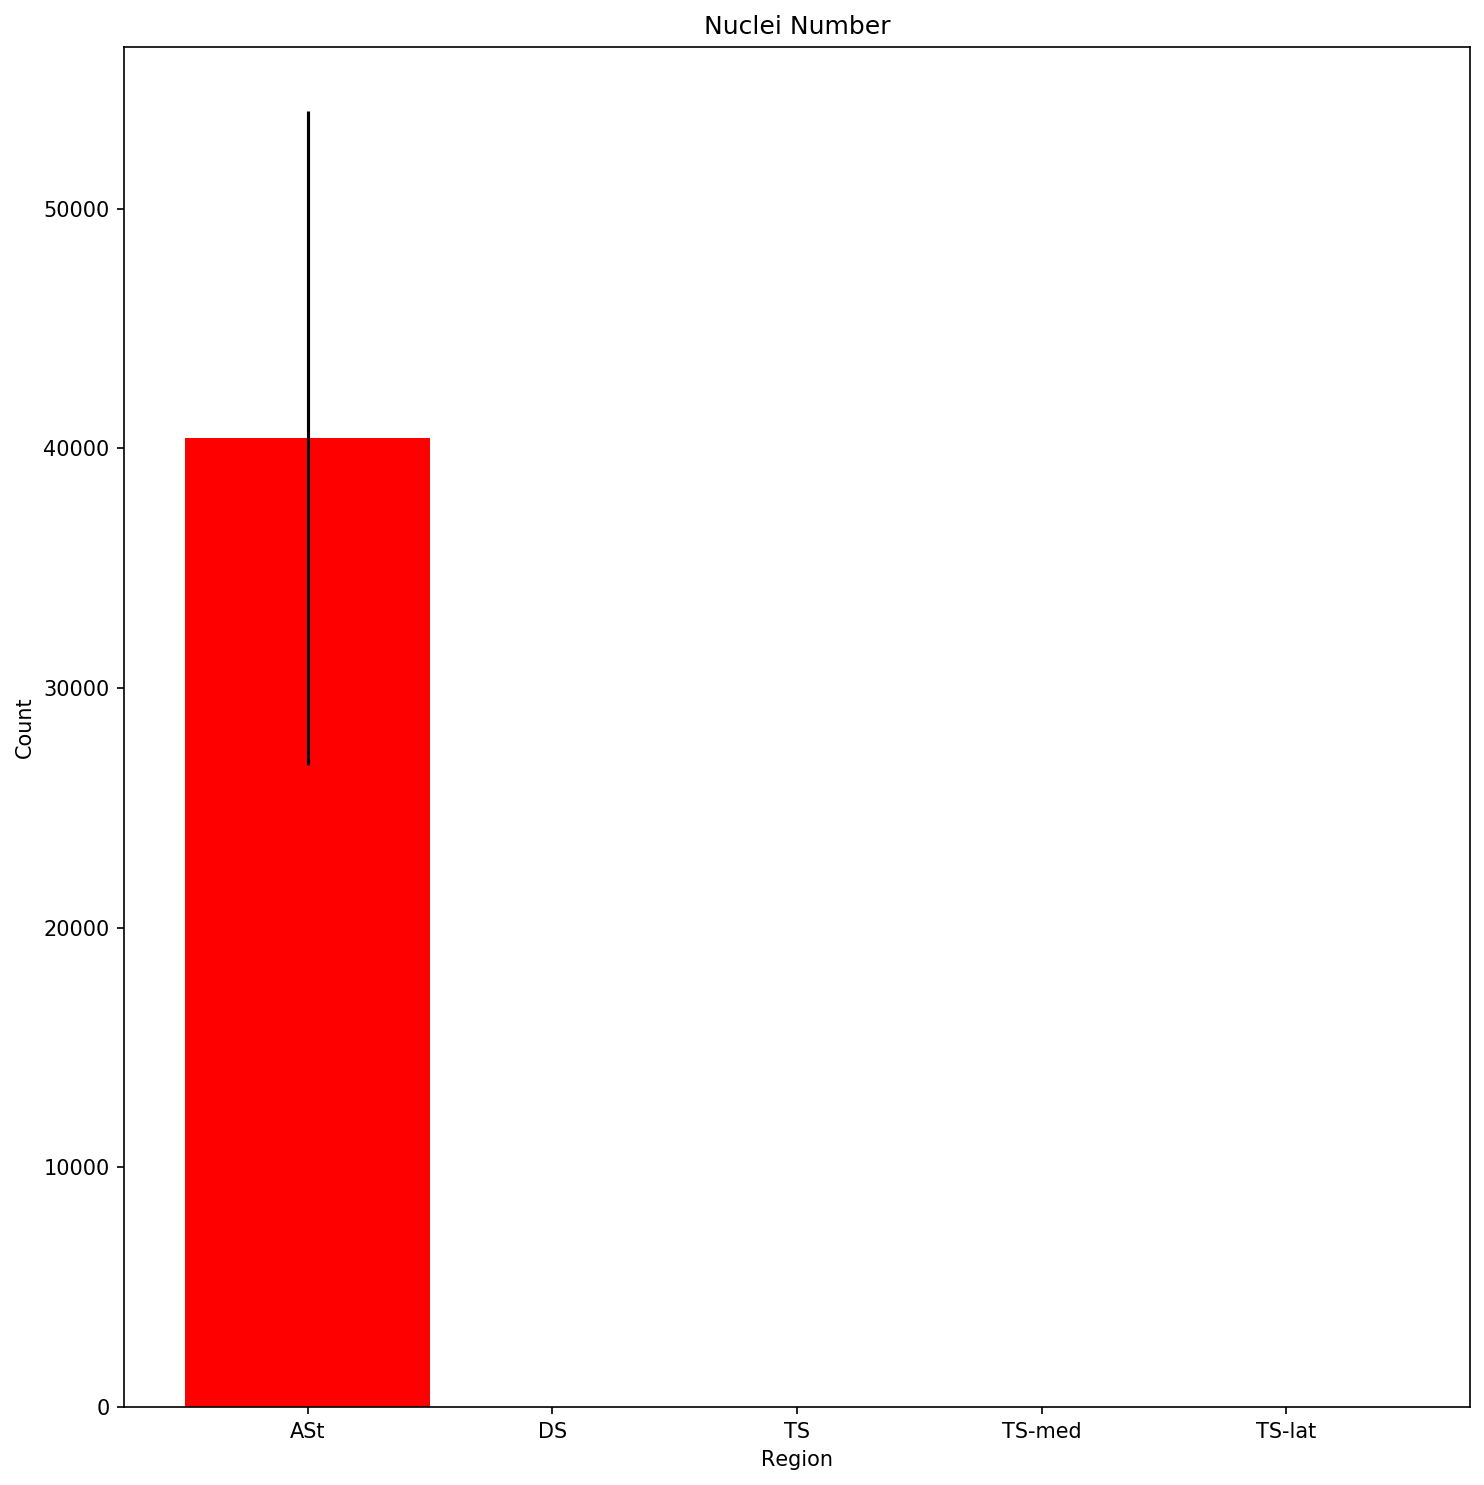

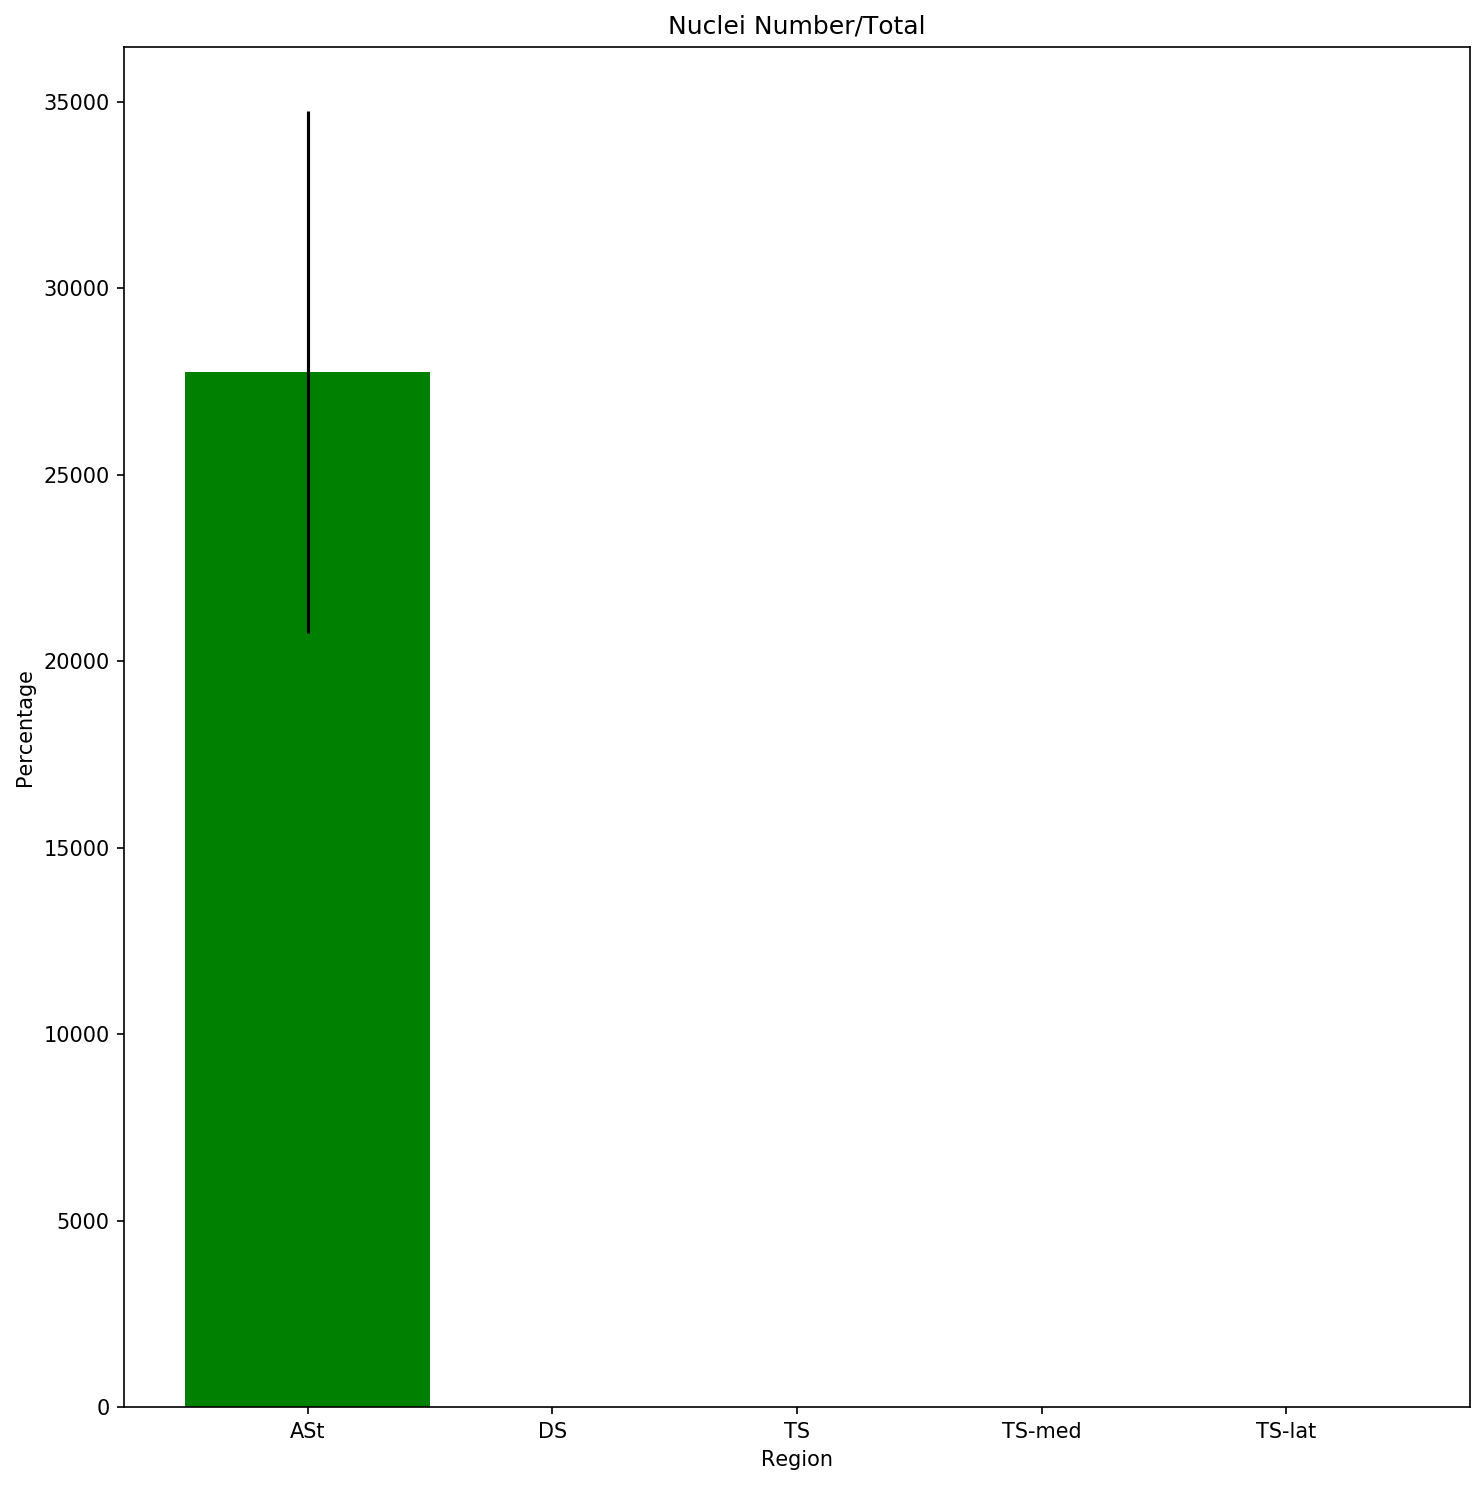

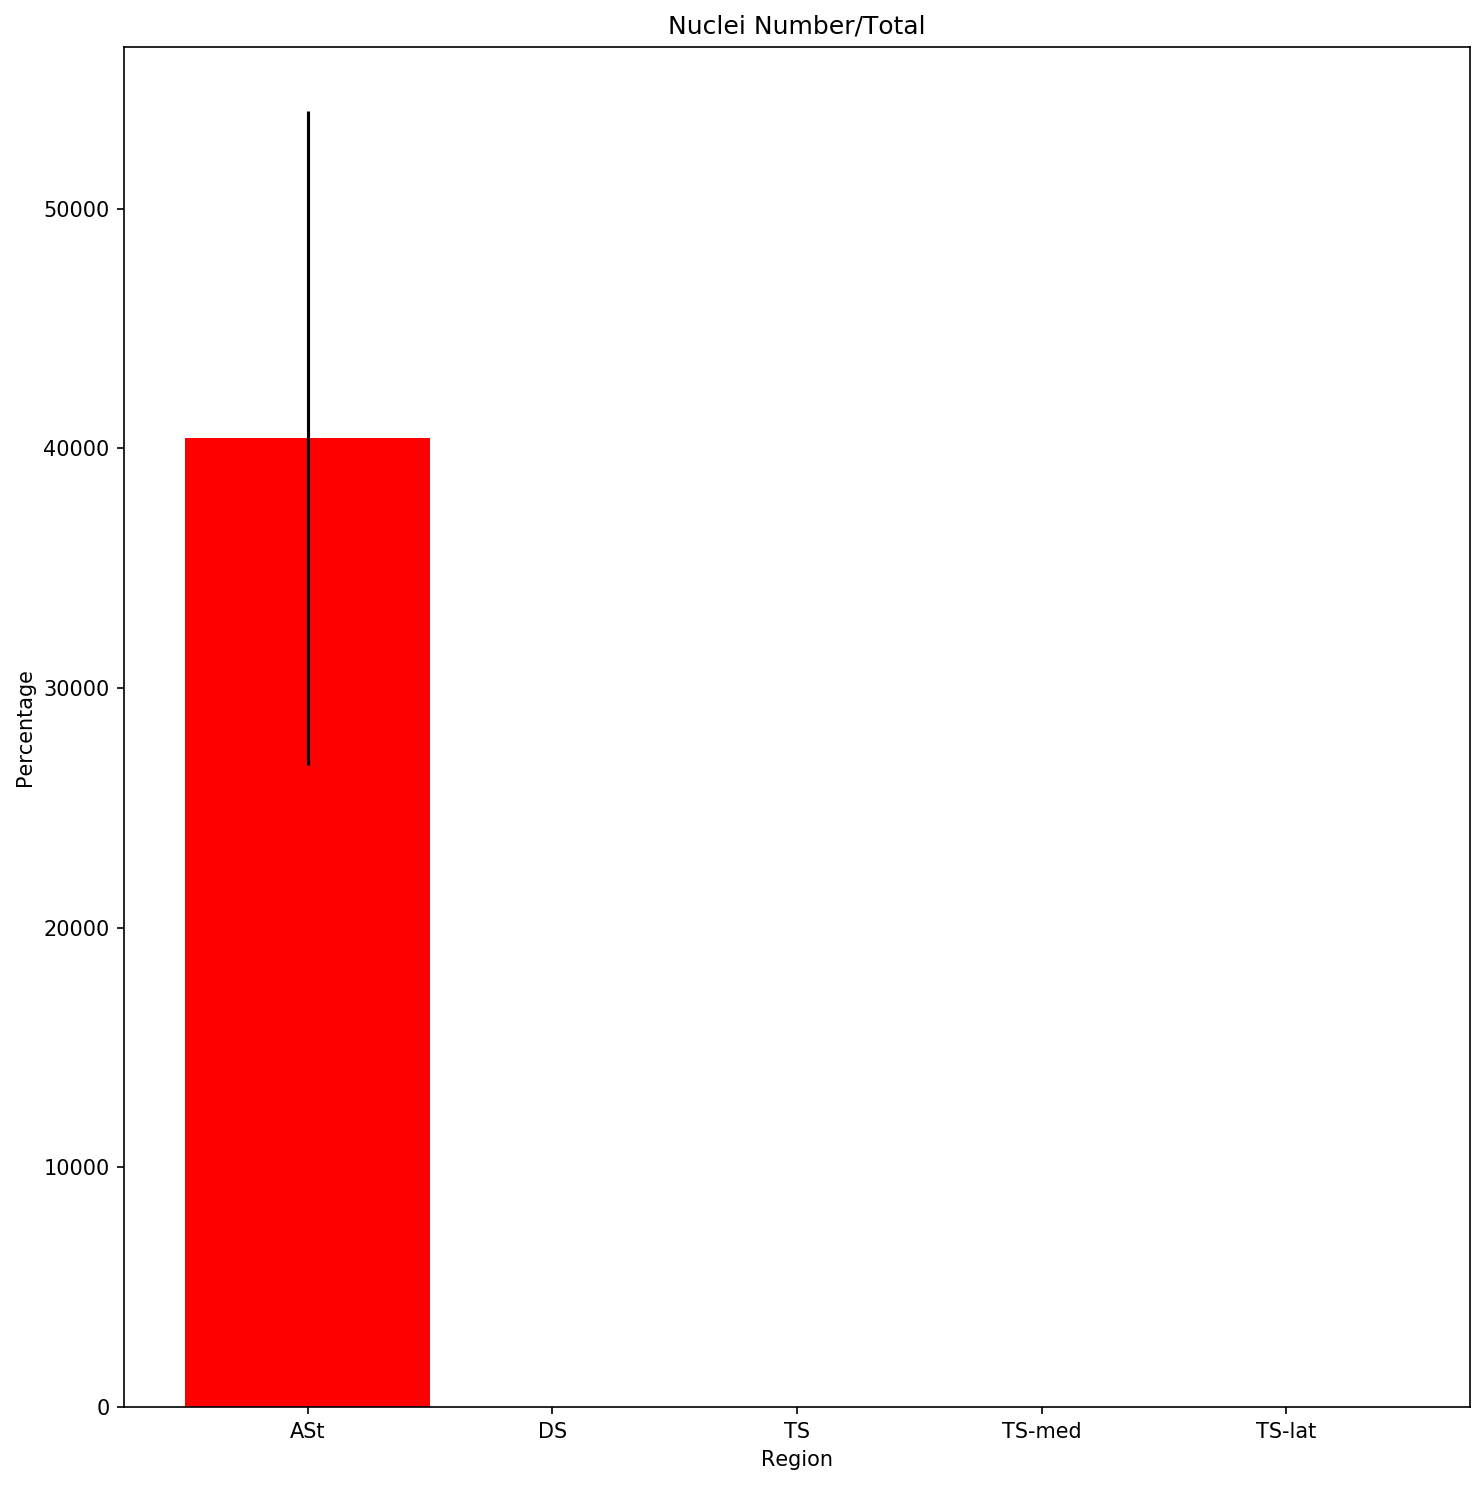

In [73]:
########## Loop through sheets and plot graphs ###########
sheet_1 = 'Area_Occupied'
sheet_2 = 'Area_Occupied_Total'
sheet_3 = 'Nuclei'
sheet_4 = 'Nuclei_Total'

sheets = [sheet_1, sheet_1, sheet_2, sheet_2, sheet_3, sheet_3, sheet_4, sheet_4]
graph_titles = ['Area Occupied', 'Area Occupied', 'Area Occupied/Total', 'Area Occupied/Total', 
                'Nuclei Number', 'Nuclei Number', 'Nuclei Number/Total', 'Nuclei Number/Total']
m = [DRD1_means, DRD2_means, DRD1_means, DRD2_means, DRD1_means, DRD2_means, DRD1_means, DRD2_means]
s = [DRD1_sems, DRD2_sems, DRD1_sems, DRD2_sems, DRD1_sems, DRD2_sems, DRD1_sems, DRD2_sems]
c = ["green", "red", "green", "red", "green", "red", "green", "red"]

# for each sublot, call the function to make a graph, and set graph title
for i in range(8): 
    fig = plot_one_graph(sheets[i], m[i], s[i], c[i])
    if i == 0 or i == 1 or i == 4 or i == 5:
        plt.ylabel("Count")
    else:
        plt.ylabel("Percentage")
    plt.title(graph_titles[i])
    plt.xlabel("Region")
    #plt.savefig('RNAscopeResults'+ str(i) + '.jpeg', dpi=300, bbox_inches='tight')
    plt.tight_layout()

In [74]:
######### MAKE H-SCORE BAR CHARTS ##############

##import excel file from previous code
data_sheets_2 = "ASt_H_scores.xlsx"

## plot_one_graph is the function that loops through sheets in the XLSX file
## Workbook argument refers to the "sheet name" and C argument refers to graph colors

def plot_one_graph(workbook, C):

## read data from excel as pandas dataframe 
    data_frame = pd.read_excel(data_sheets_2, sheet_name = workbook)

## sort puncta into bins grouped by 3 puncta/cell
    bin1 = []
    bin2 = []
    bin3 = []
    bin4 = []
    bin5 = []
    bin6 = []
    bin7 = []
    bin8 = []
    bin9 = []
    bin10 = []
    bin11 = []
    bin12 = []
    bin13 = []
    bin14 = []
    bin15 = []
    bin16 = []
    bin17 = []
    bin18 = []
    bin19 = []
    bin20 = []
    bin21 = []
    bin22 = []
    bin23 = []

## Bin labels correspond to the number of puncta/cell

    labels = ['1-3', '4-6', '7-9', '10-12','13-15', '16-18', '19-21', '22-24', 
              '25-27', '28-30', '31-33', '34-36', '37-39', '40-42', '43-45', '46-48',
              '49-51', '52-54', '55-57', '58-60', '61-63', '64-66', '67-69']

## go through the list of labels, and each column to bin data based on the number of puncta/cells

    for j in range(len(labels)):
        for i in range(len(data_frame.columns)):
            slicecolumn = pd.DataFrame({'Column': data_frame.iloc[:,i]})
            slicecolumn['labels'] = pd.cut(x=slicecolumn['Column'], bins=[0, 4, 7, 10, 13, 
                                                                          16, 19, 22, 25, 28, 
                                                                          31, 34, 37, 40, 43, 
                                                                          46, 49, 52, 55, 58, 
                                                                          61, 64, 67, 69],labels=['1-3', '4-6', '7-9', '10-12','13-15', 
                                                                                              '16-18', '19-21', '22-24', '25-27', '28-30', 
                                                                                              '31-33', '34-36', '37-39', '40-42', '43-45', 
                                                                                              '46-48','49-51', '52-54', '55-57', '58-60', 
                                                                                              '61-63', '64-66', '67-69'], right=False)
            if j == 0:
                bin1.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 1:
                bin2.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 2:
                bin3.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 3:
                bin4.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 4:
                bin5.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 5:
                bin6.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 6:
                bin7.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 7:
                bin8.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 8:
                bin9.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 9:
                bin10.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 10:
                bin11.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 11:
                bin12.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 12:
                bin13.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 13:
                bin14.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 14:
                bin15.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 15:
                bin16.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 16:
                bin17.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 17:
                bin18.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 18:
                bin19.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 19:
                bin20.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 20:
                bin21.append(slicecolumn['labels'].eq(labels[j]).sum())
            elif j == 21:
                bin22.append(slicecolumn['labels'].eq(labels[j]).sum()) 
            elif j == 22:
                bin23.append(slicecolumn['labels'].eq(labels[j]).sum()) 

## find the means and standard error of the mean for each bin 

    bins = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10, bin11, bin12, bin13, bin14, bin15, 
    bin16, bin17, bin18, bin19, bin20, bin21, bin22, bin23] 
    means = []
    sems = []
    for i in bins:
        x = np.mean(i)
        y = stats.sem(i)
        means.append(x)
        sems.append(y)
        
## plot graph the output as a bar chart with error bars 
    x = range(0,69)
    fig = plt.figure(dpi=150,figsize=(20,10))
    fig.add_subplot(111)
    labels = ("1-3", "4-6", "7-9", "10-12", '13-15', '16-18', '19-21', '22-24', 
              '25-27', '28-30', '31-33', '34-36', '37-39', '40-42', '43-45', '46-48',
              '49-51', '52-54', '55-57', '58-60', '61-63', '64-66', '67-69')
    positions = (1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67)
    plt.xticks(positions, labels)
    plt.xlabel("H-Score")
    plt.ylabel("Count")
    plt.ylim(0,150)
    plt.bar([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67], means, yerr=sems, width = 3, color = C) 
    return fig

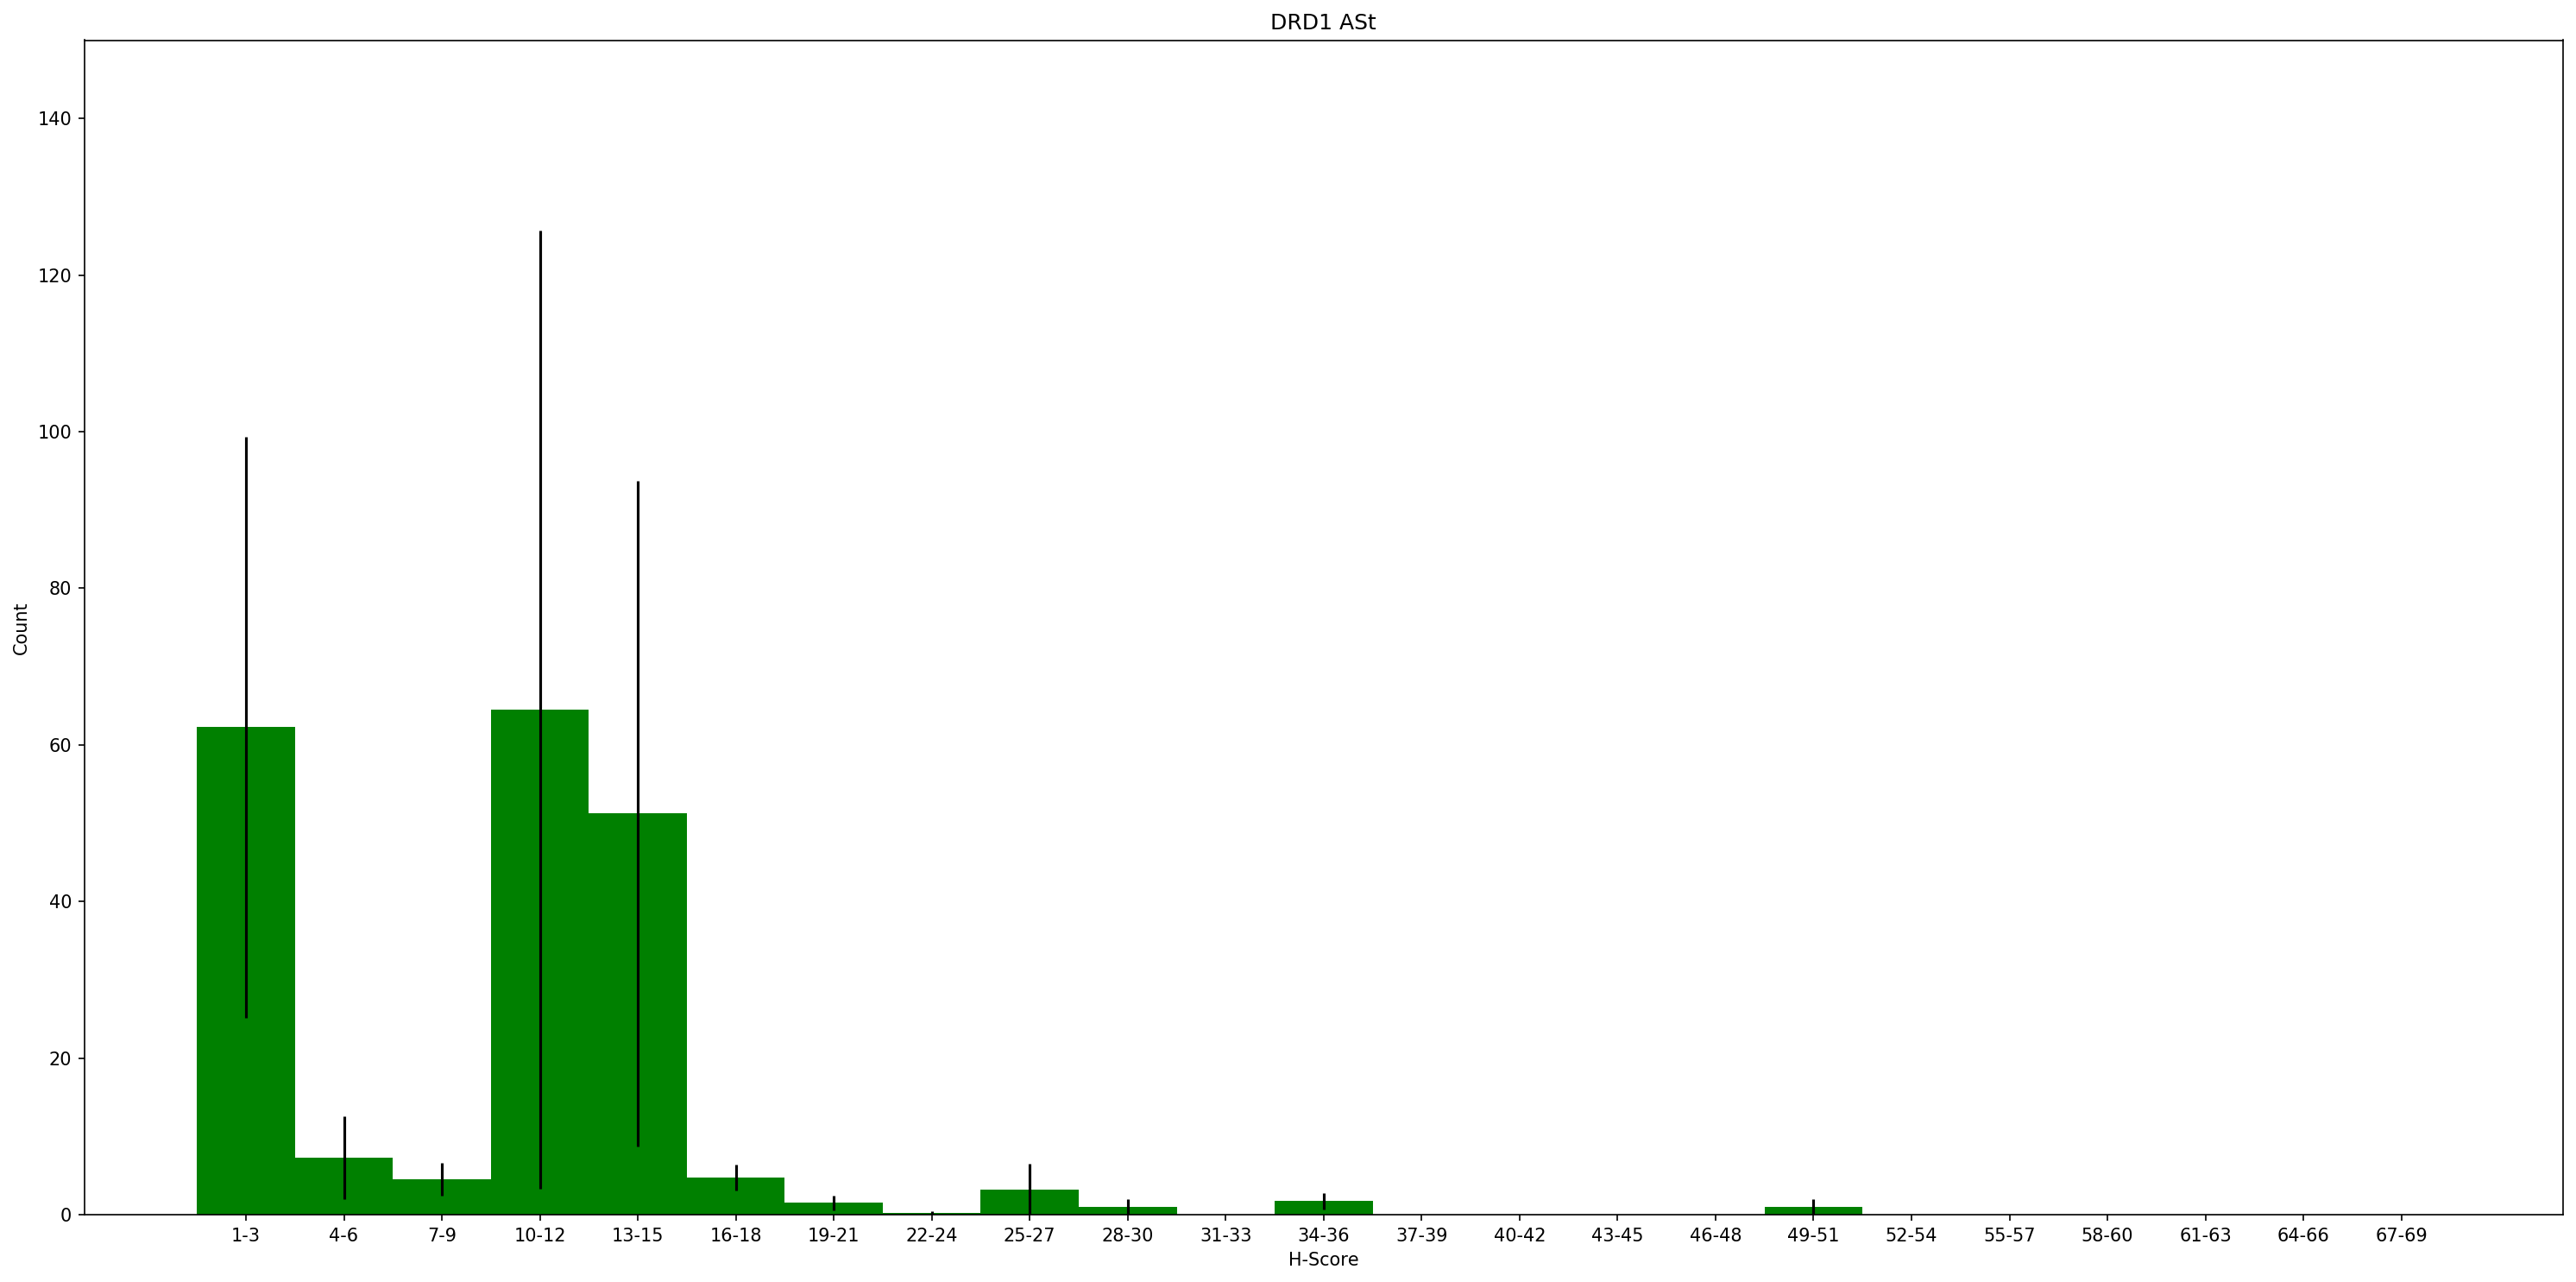

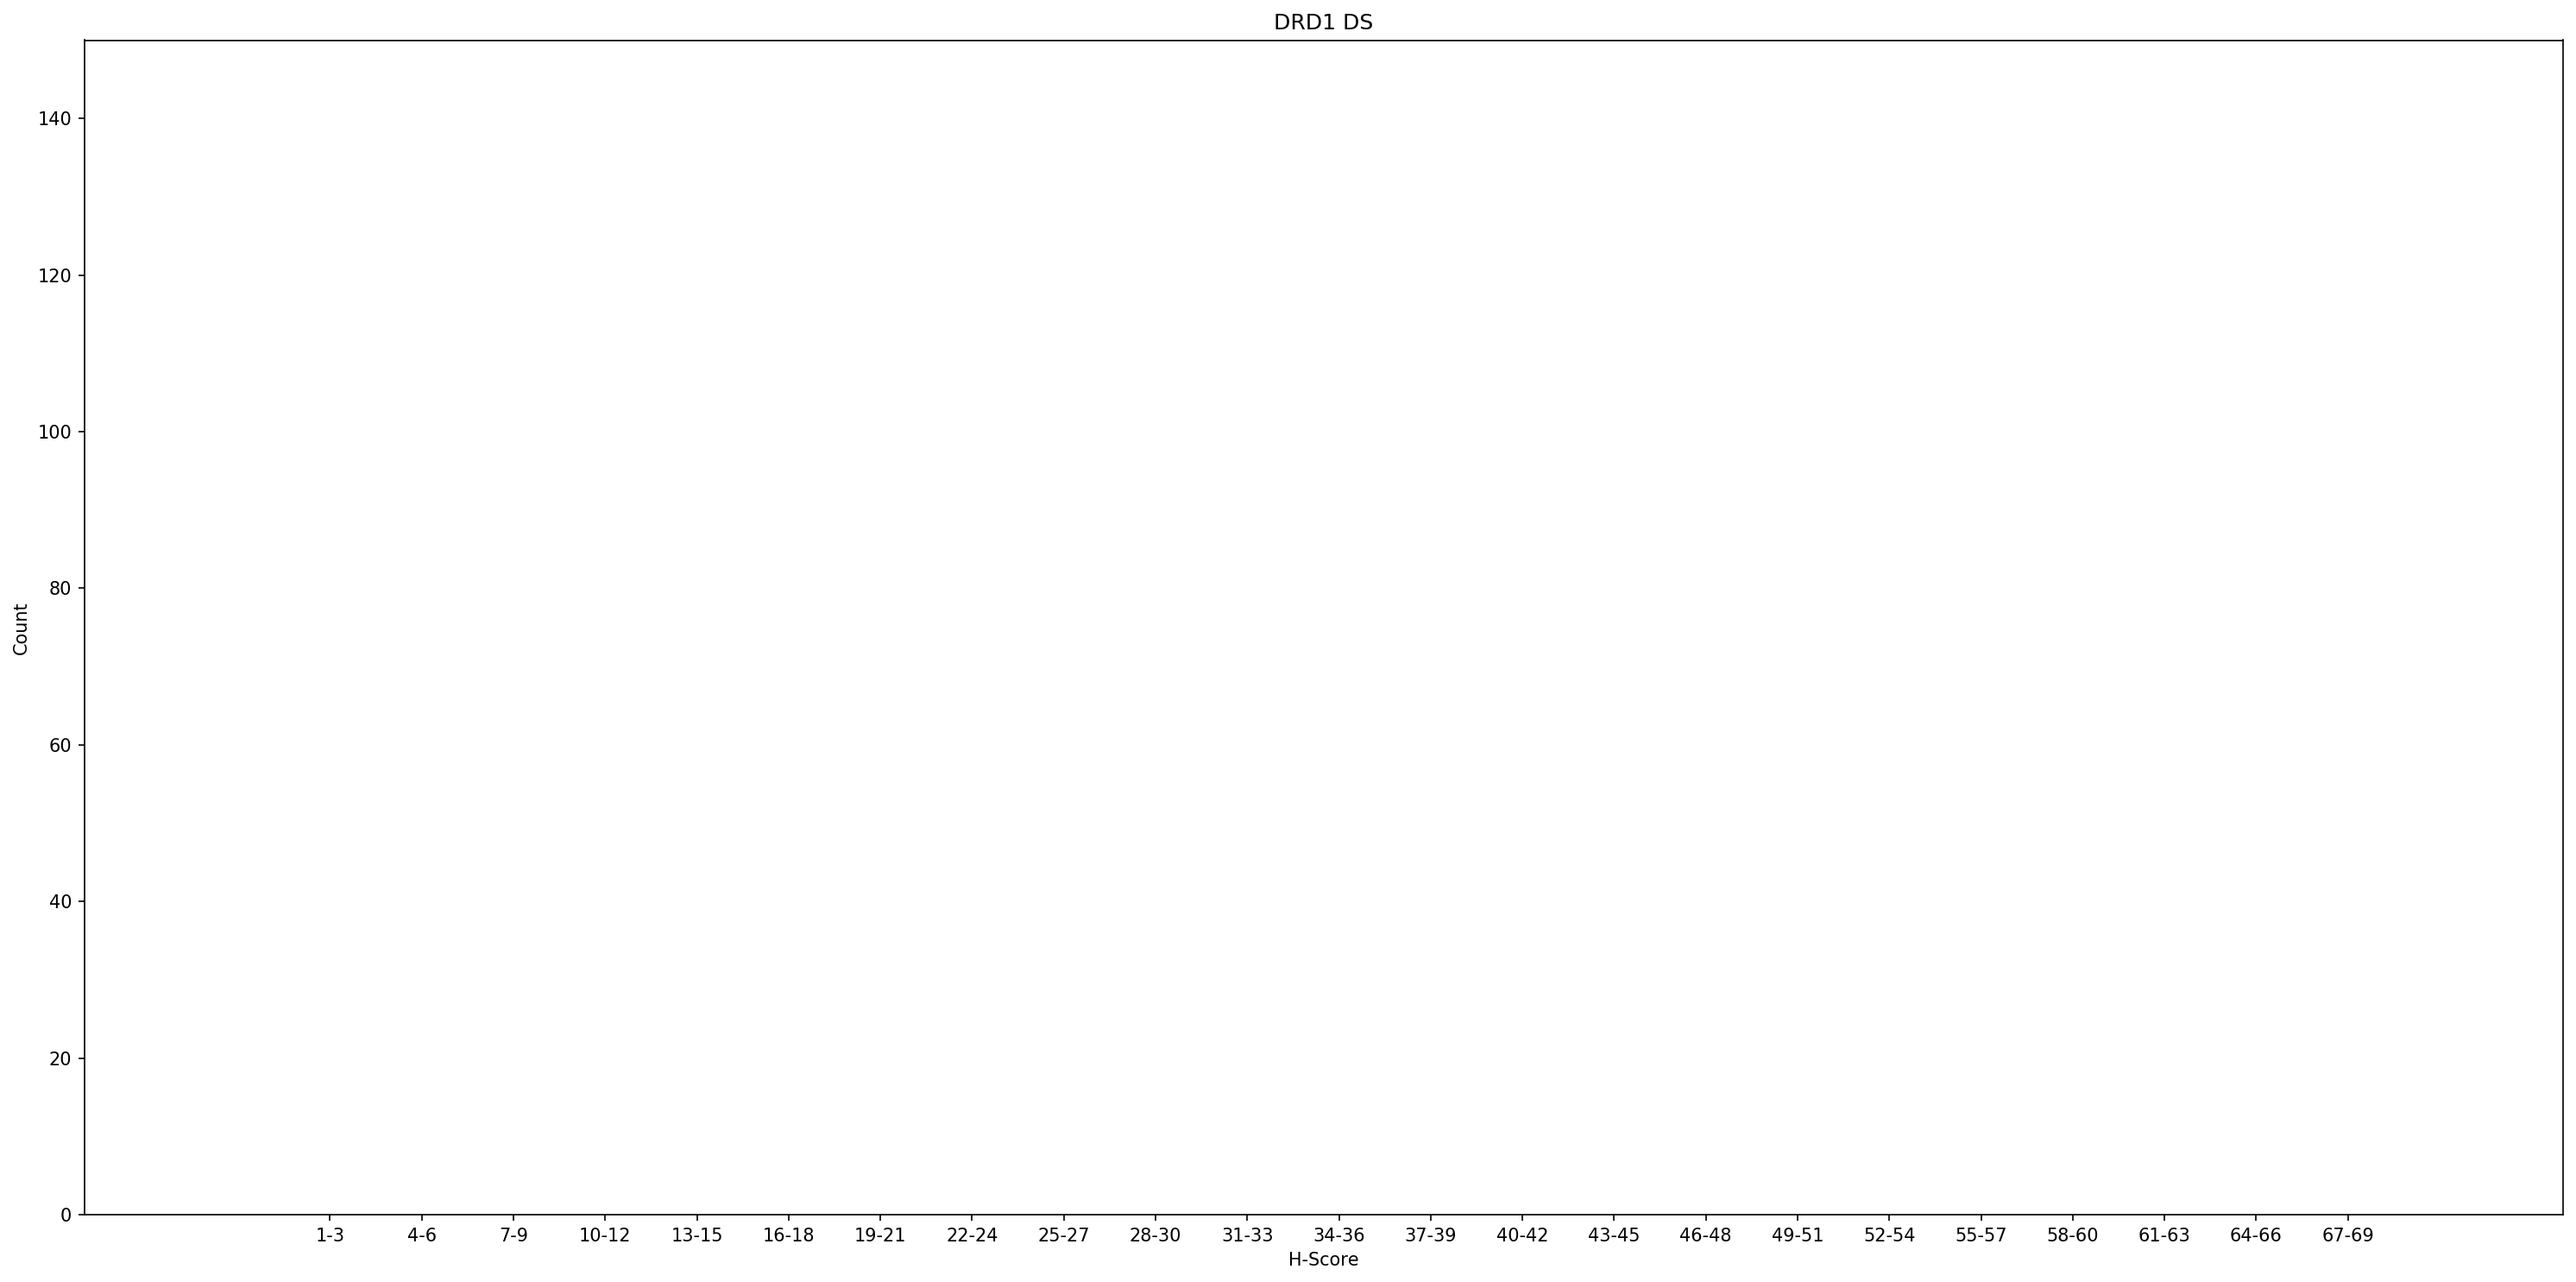

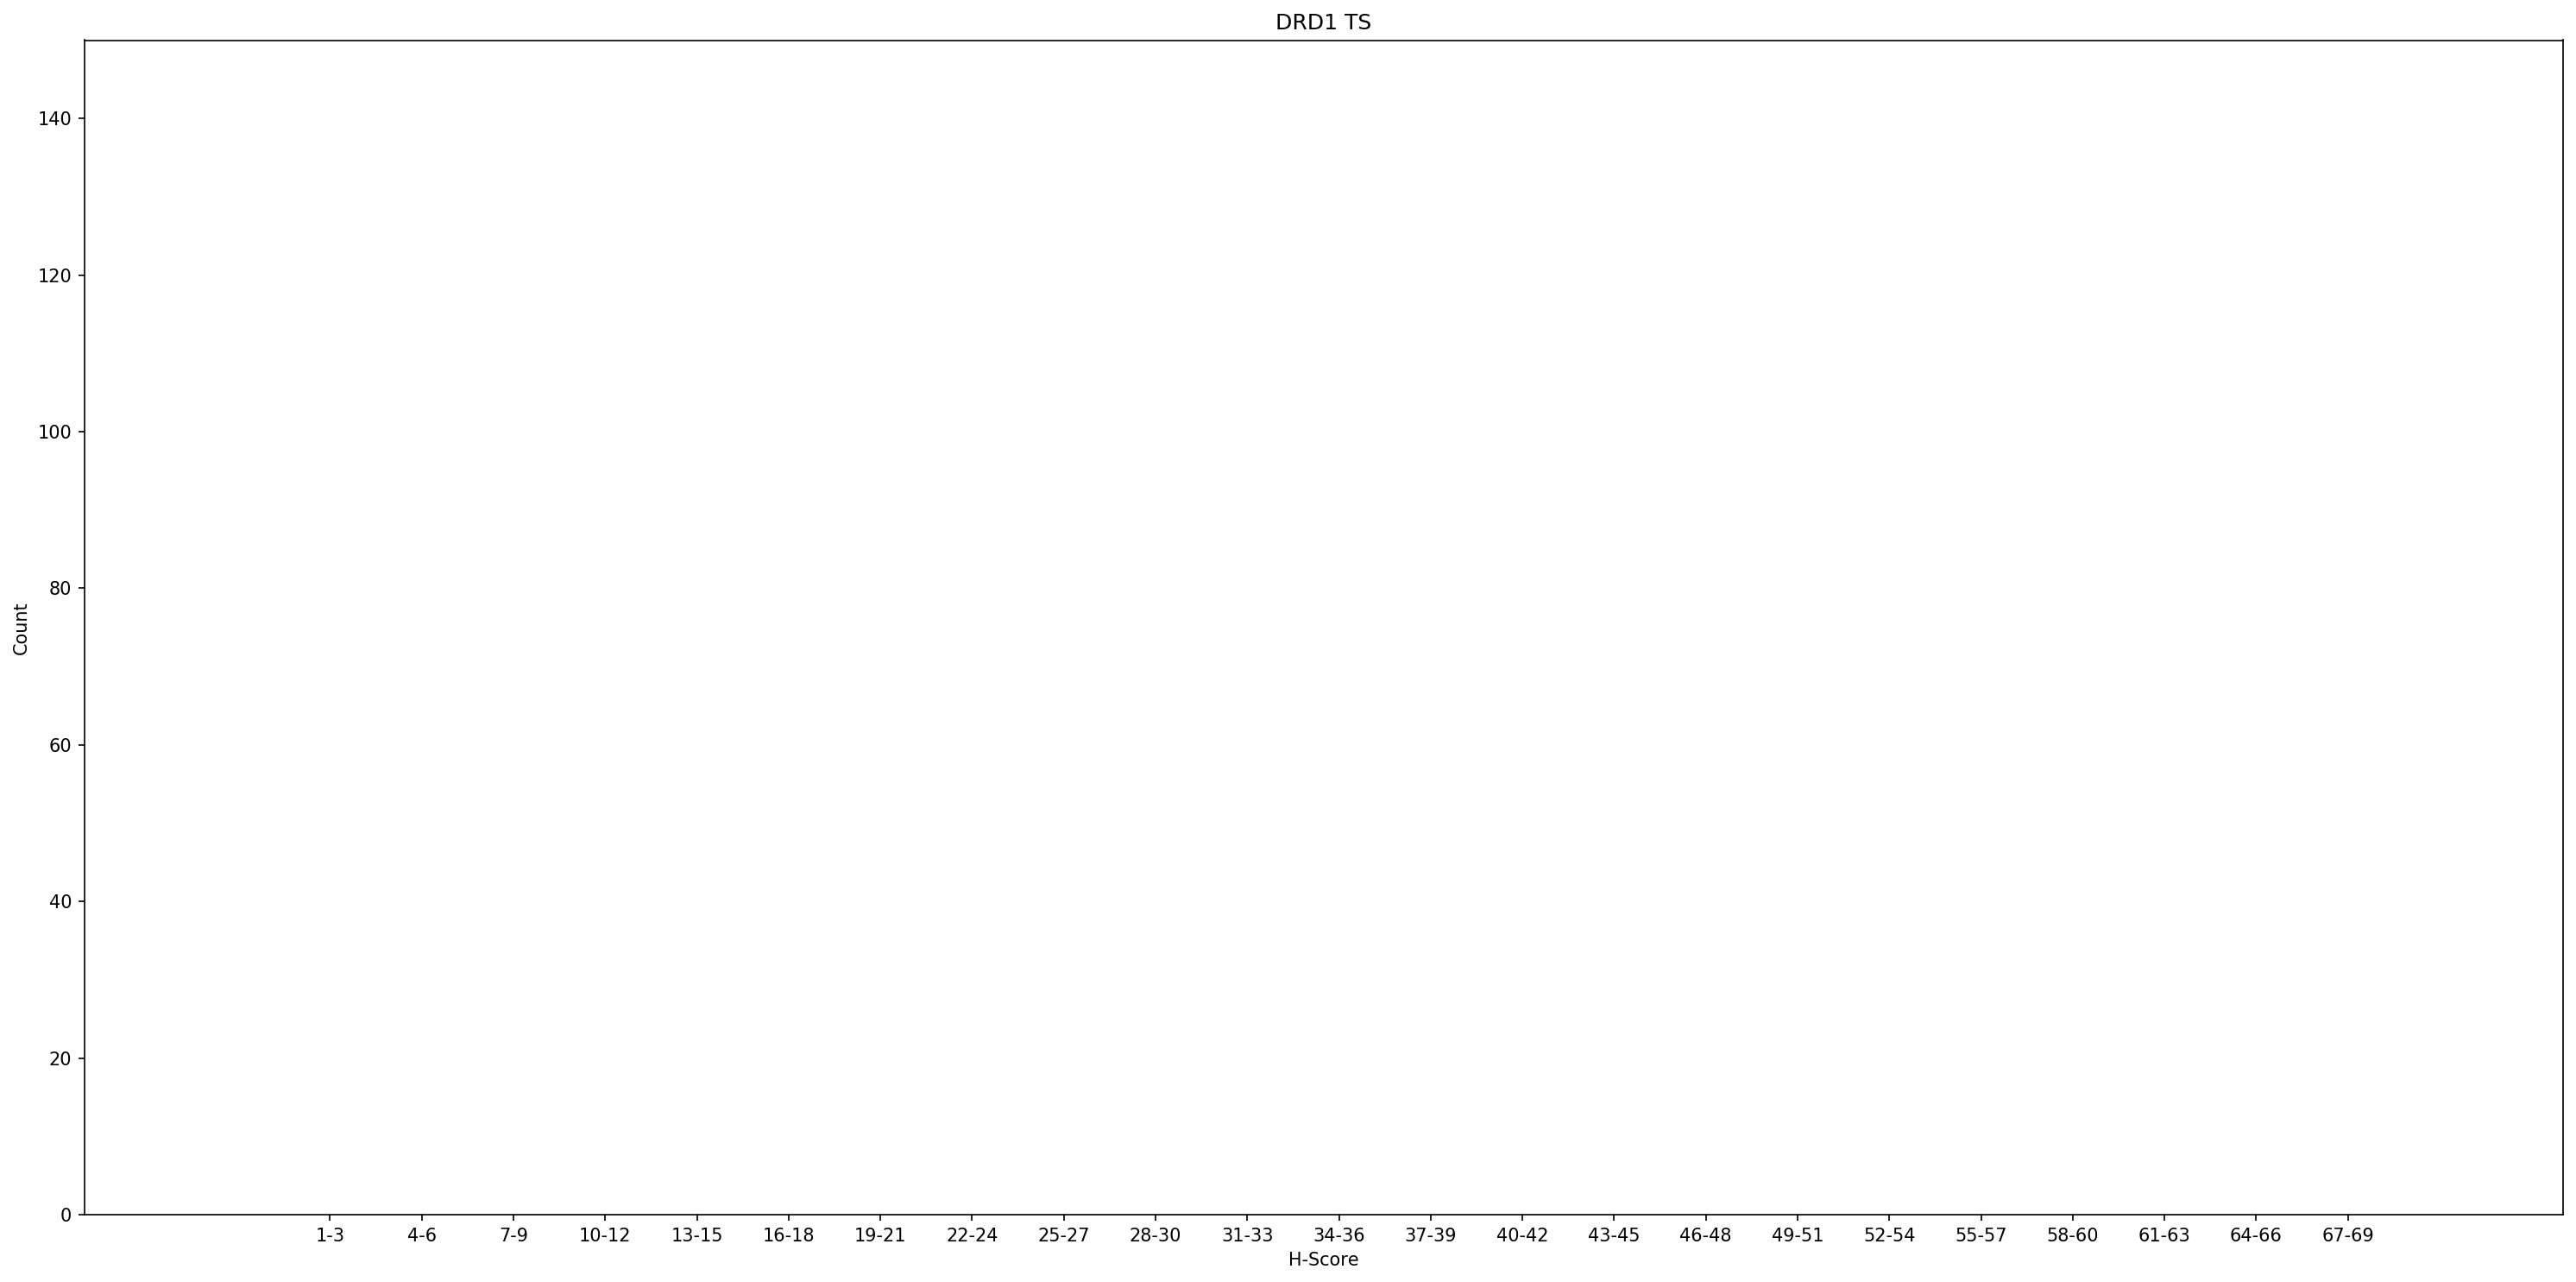

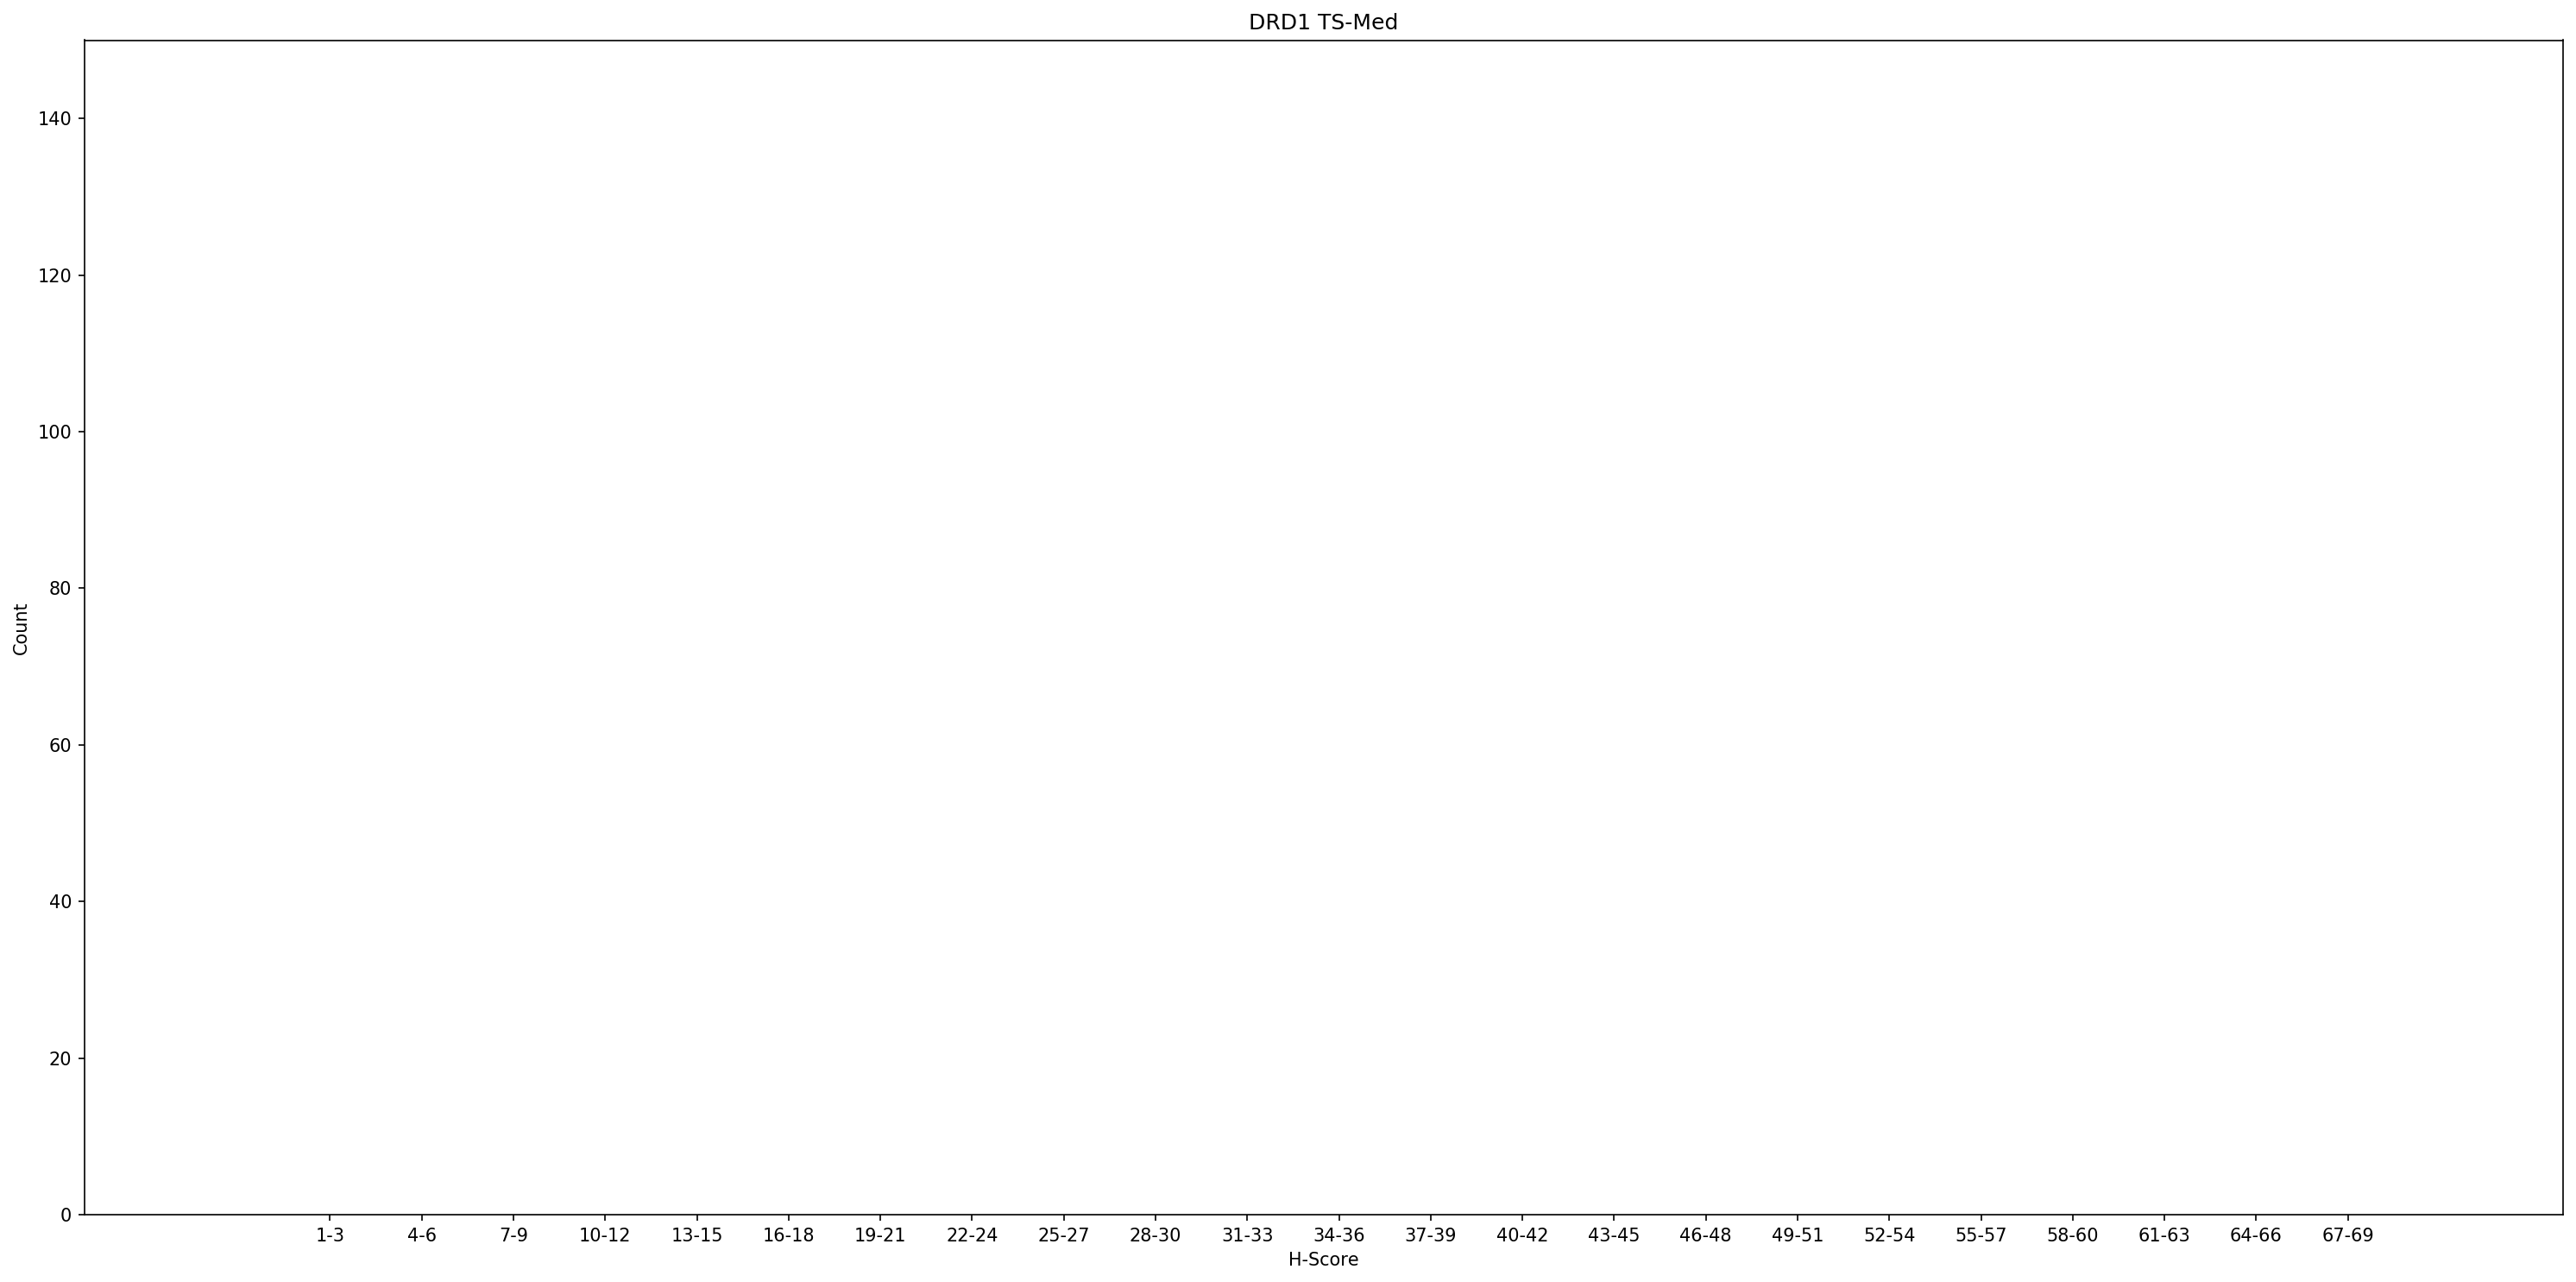

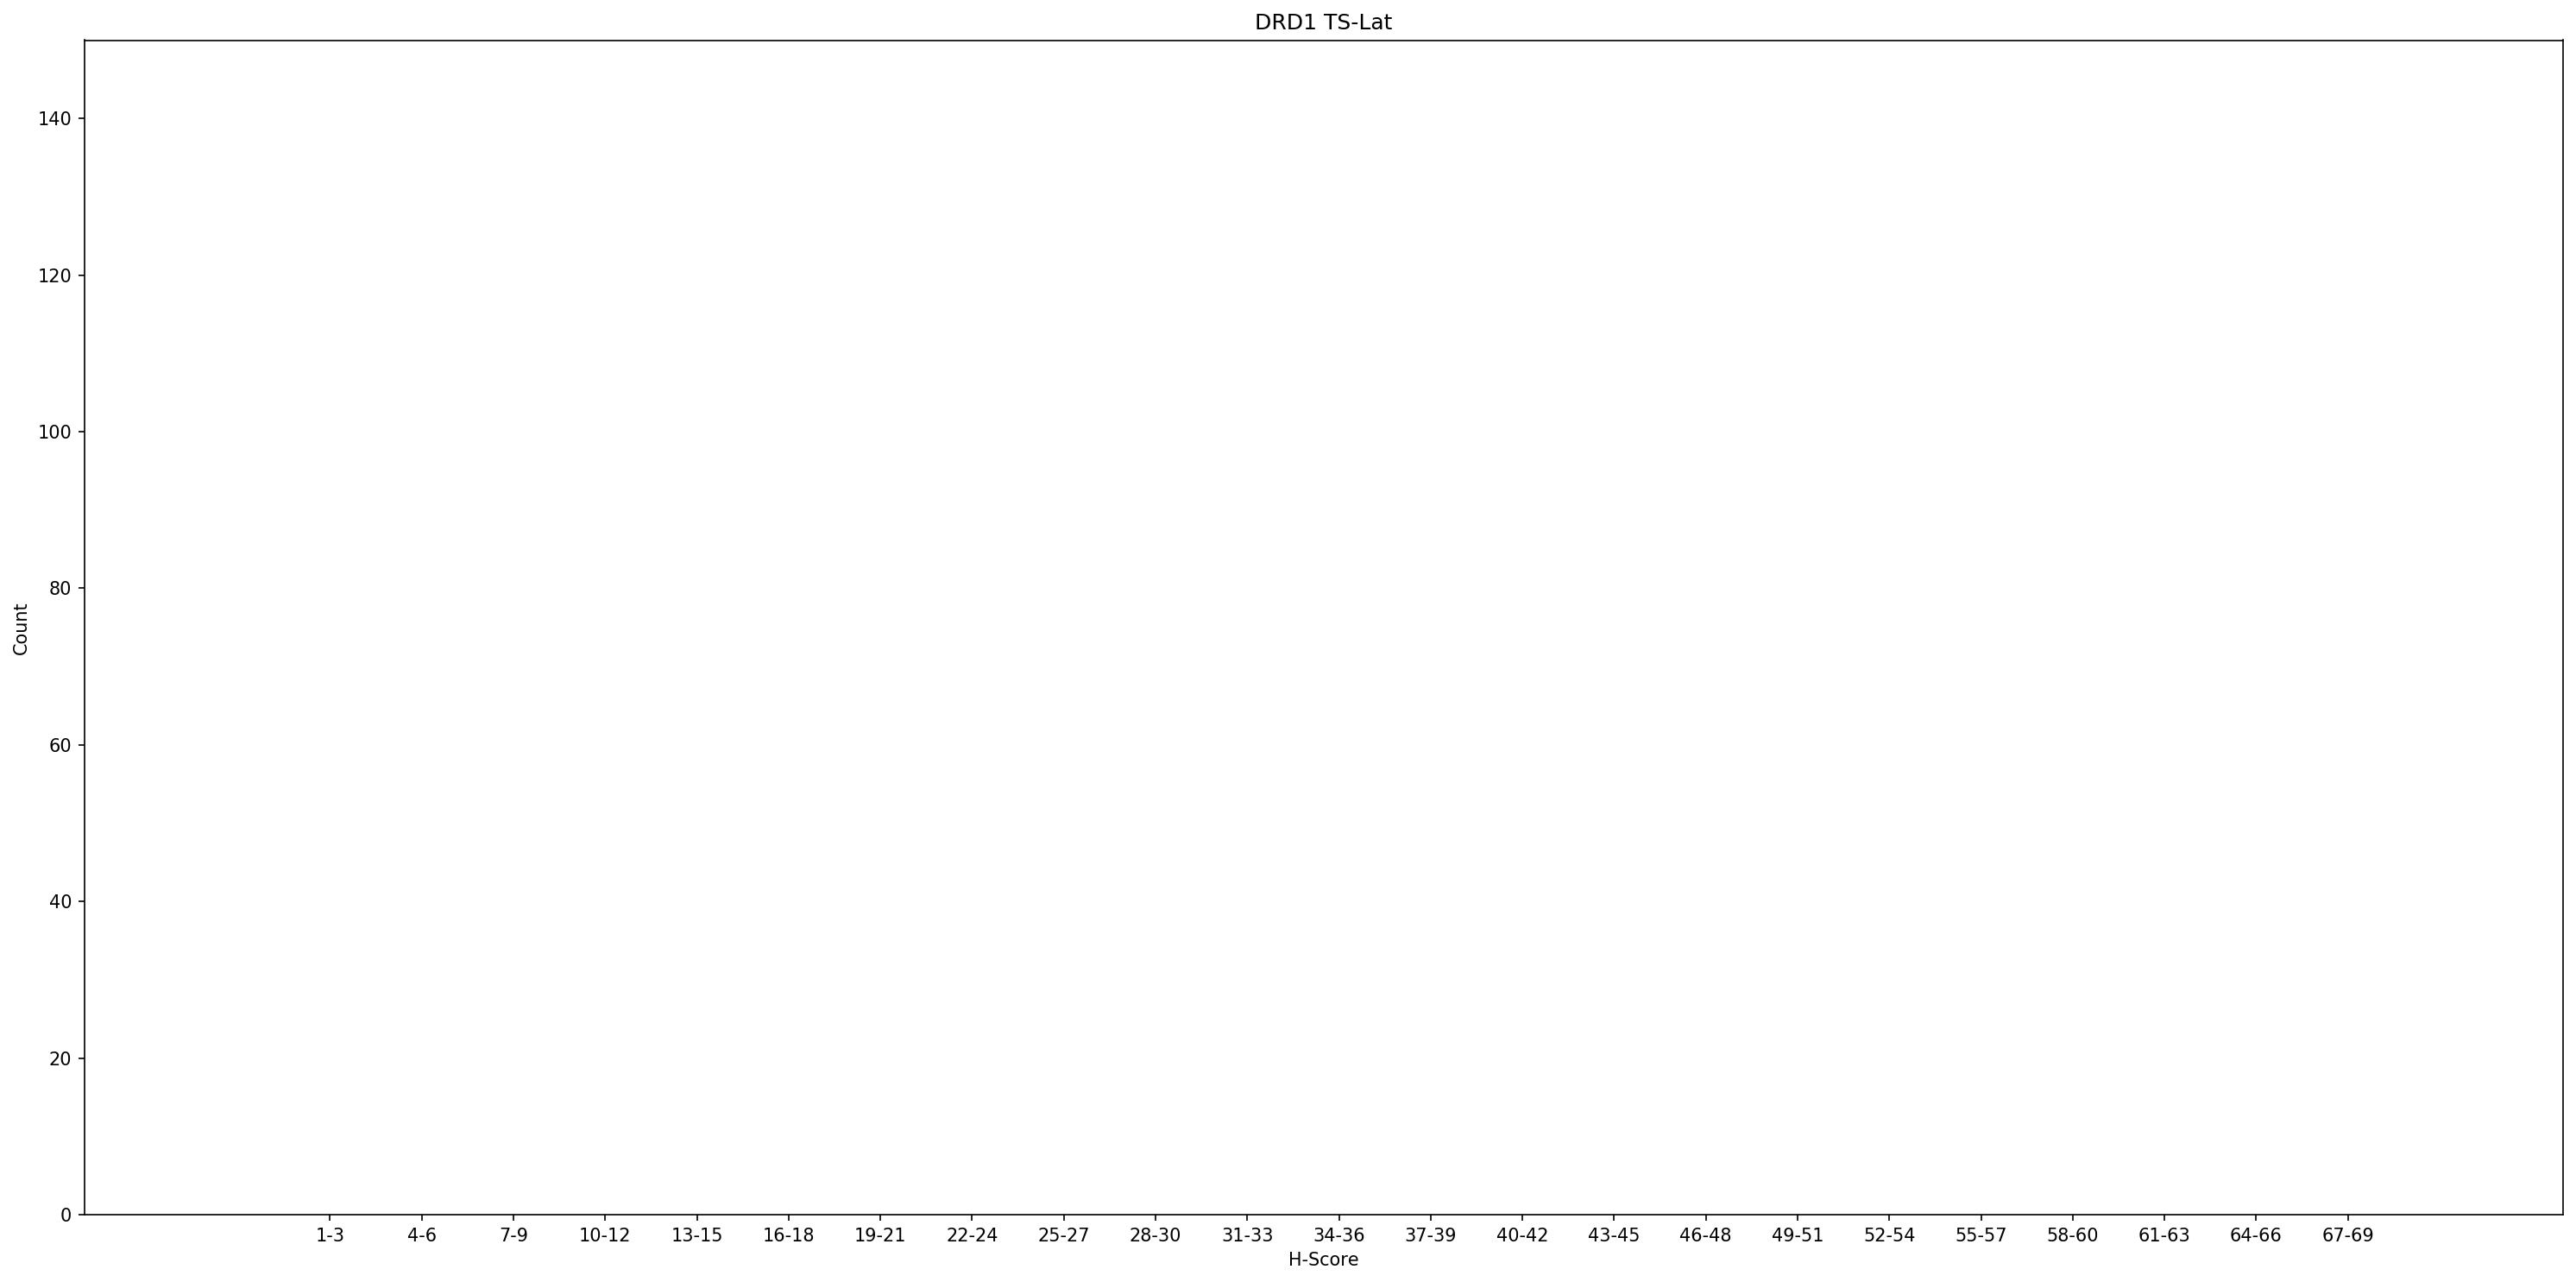

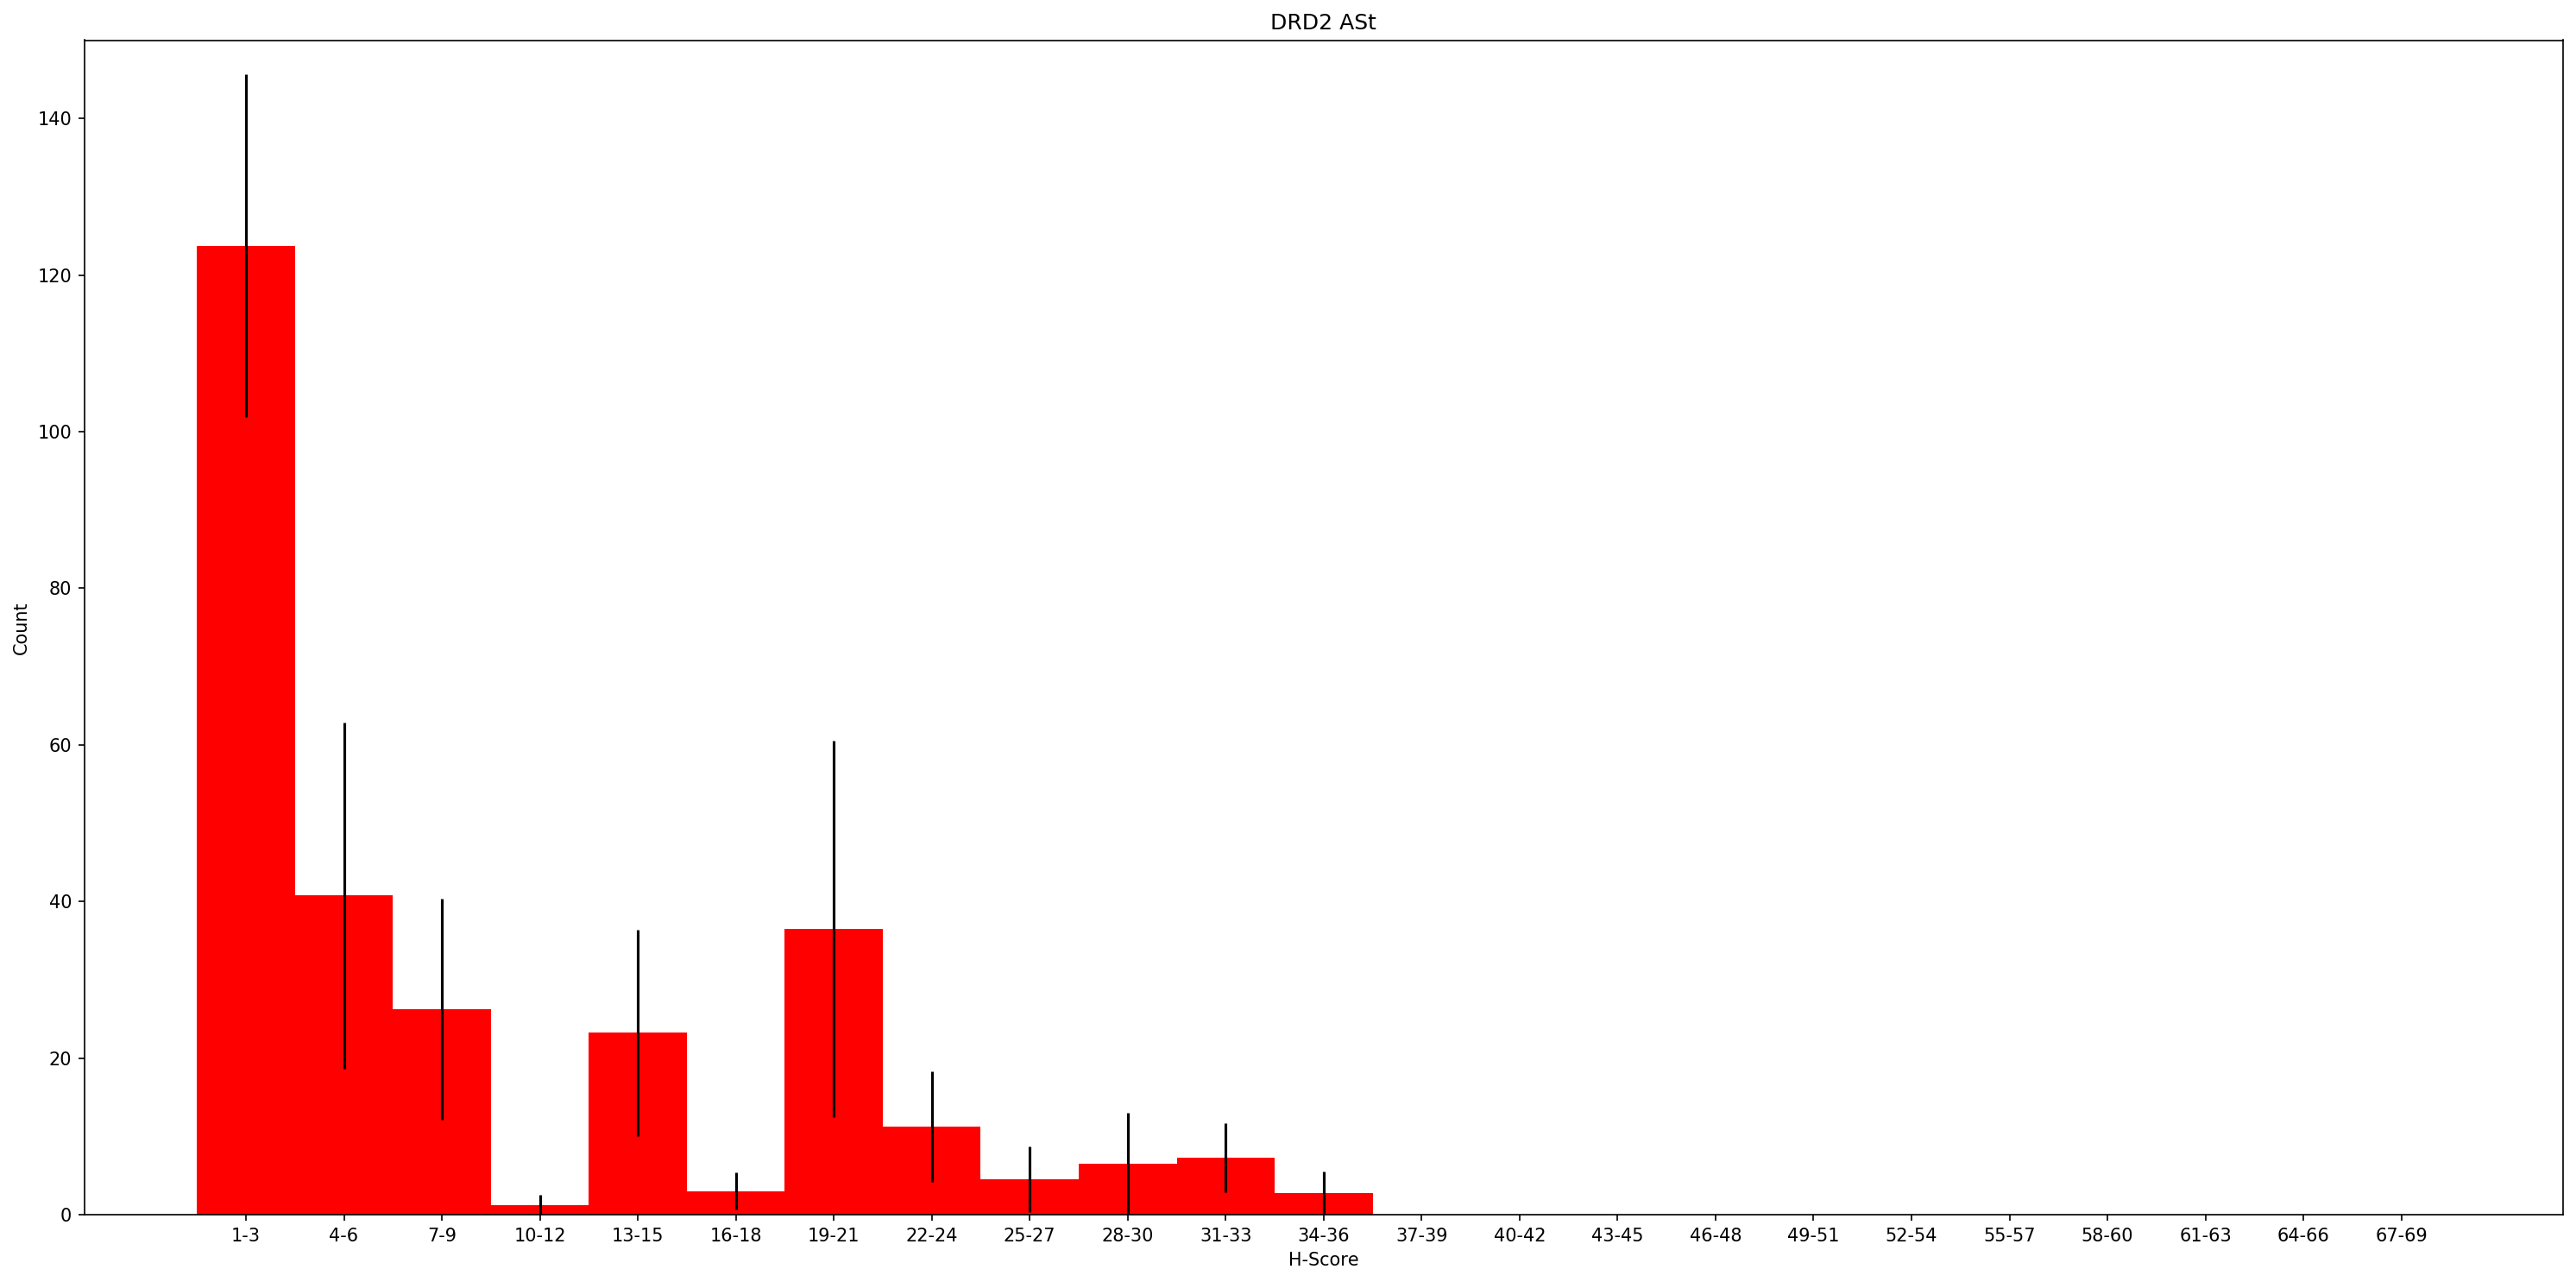

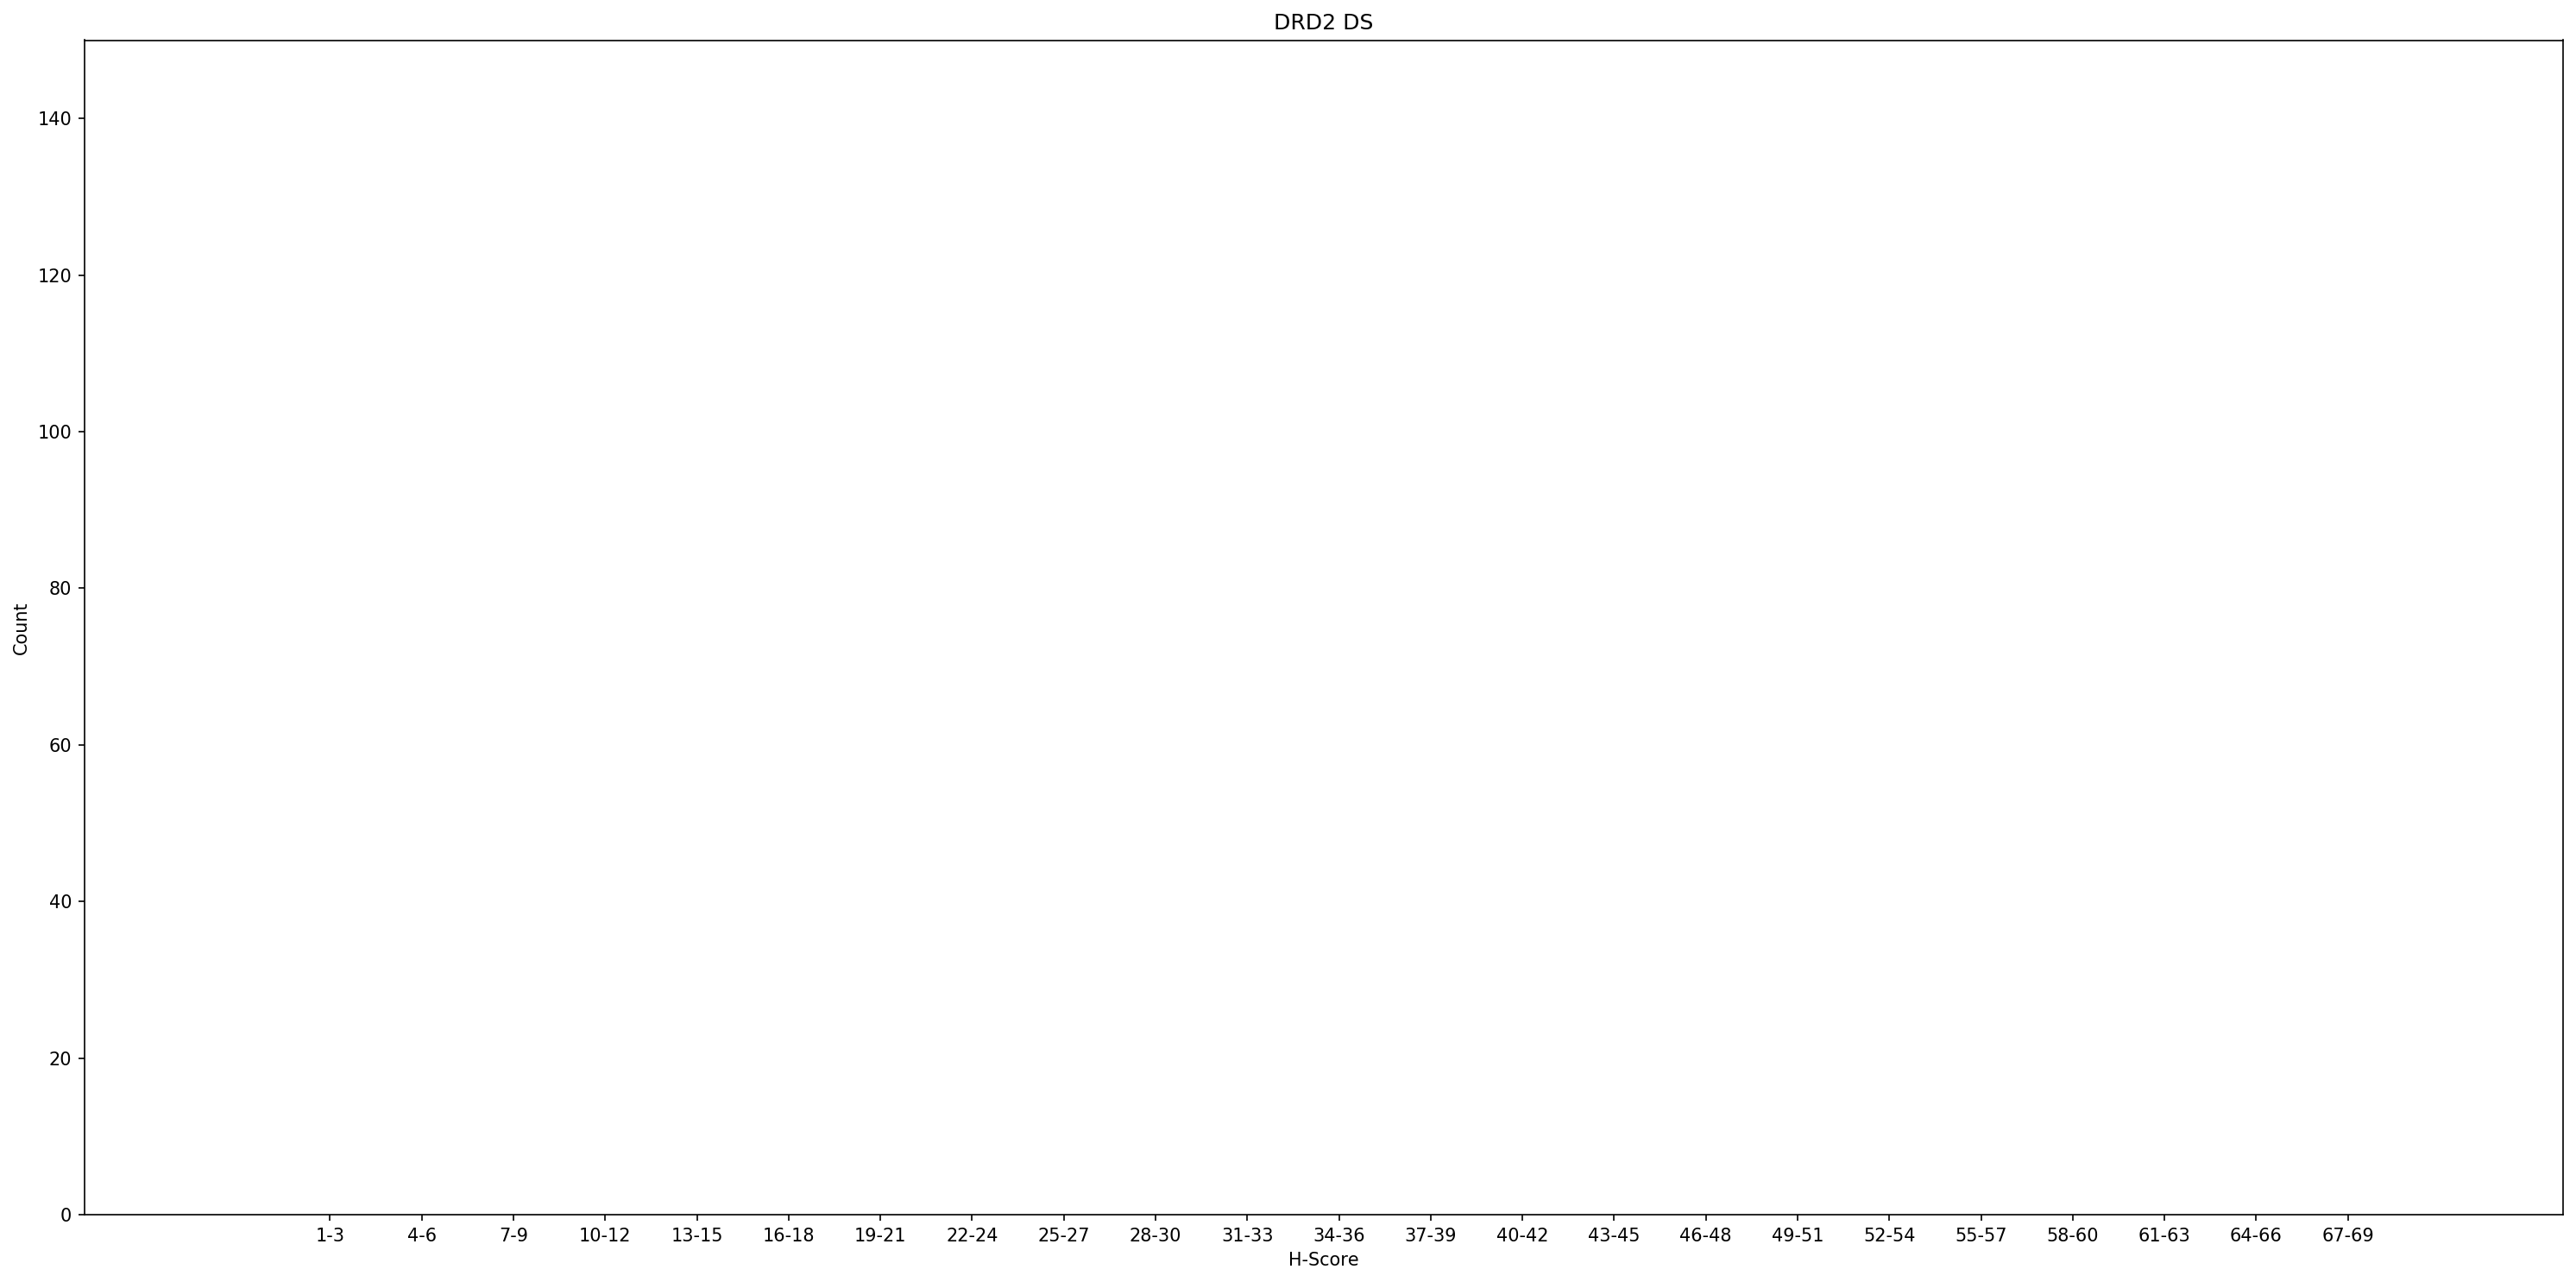

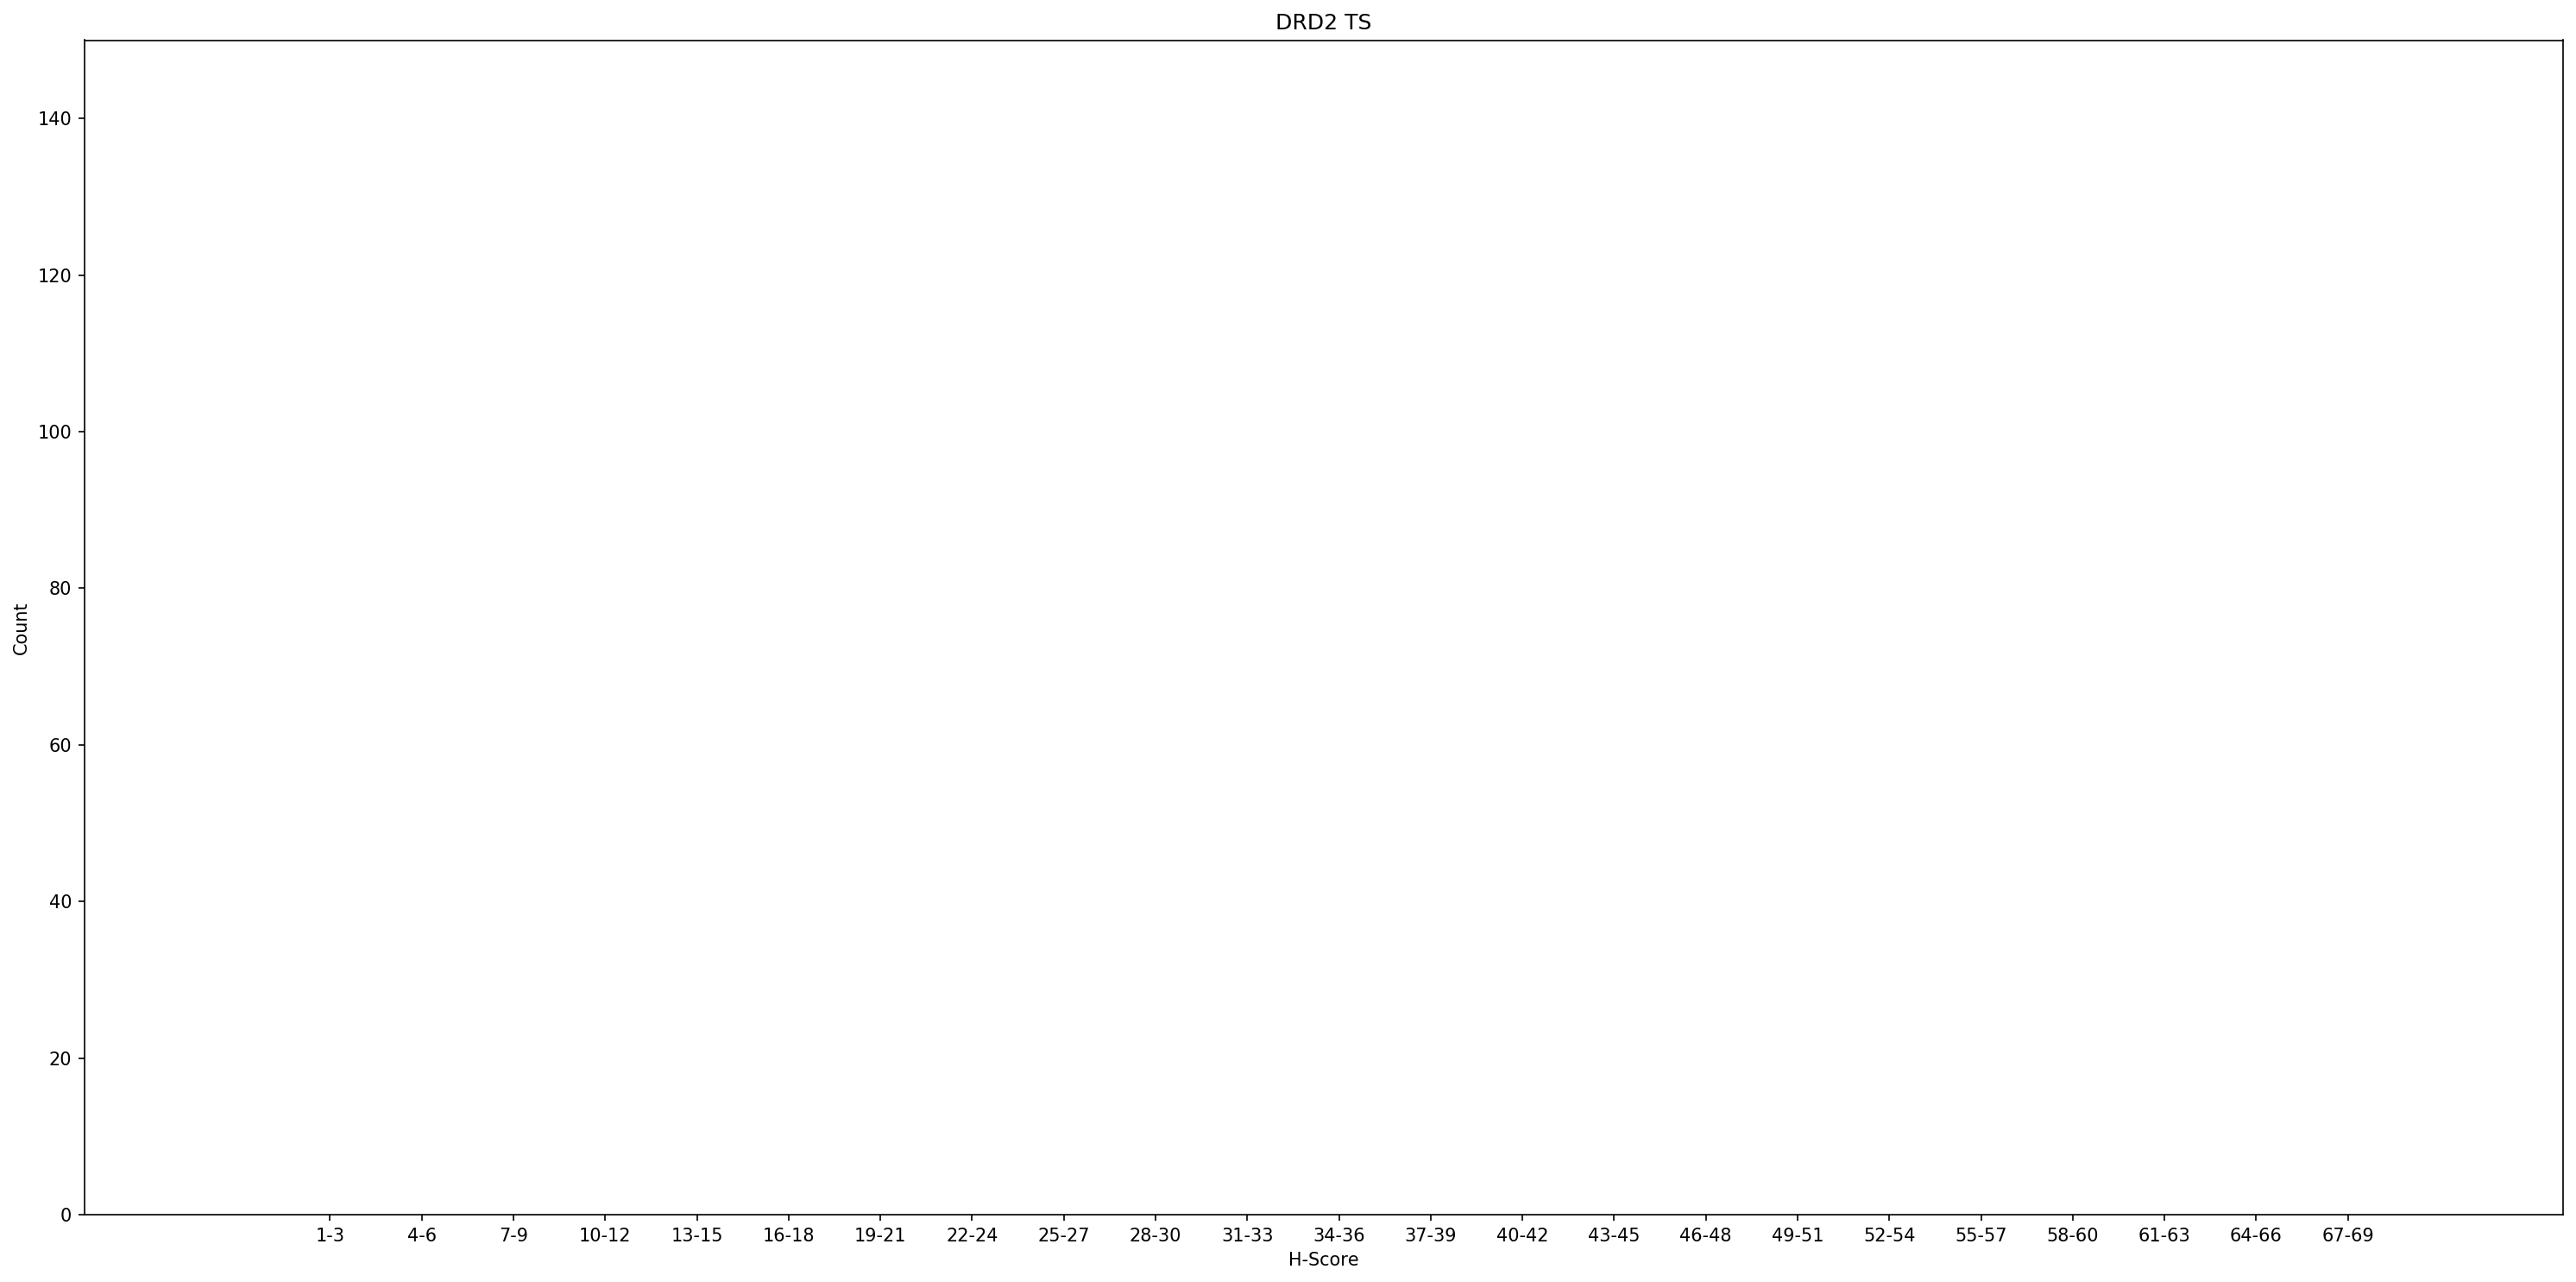

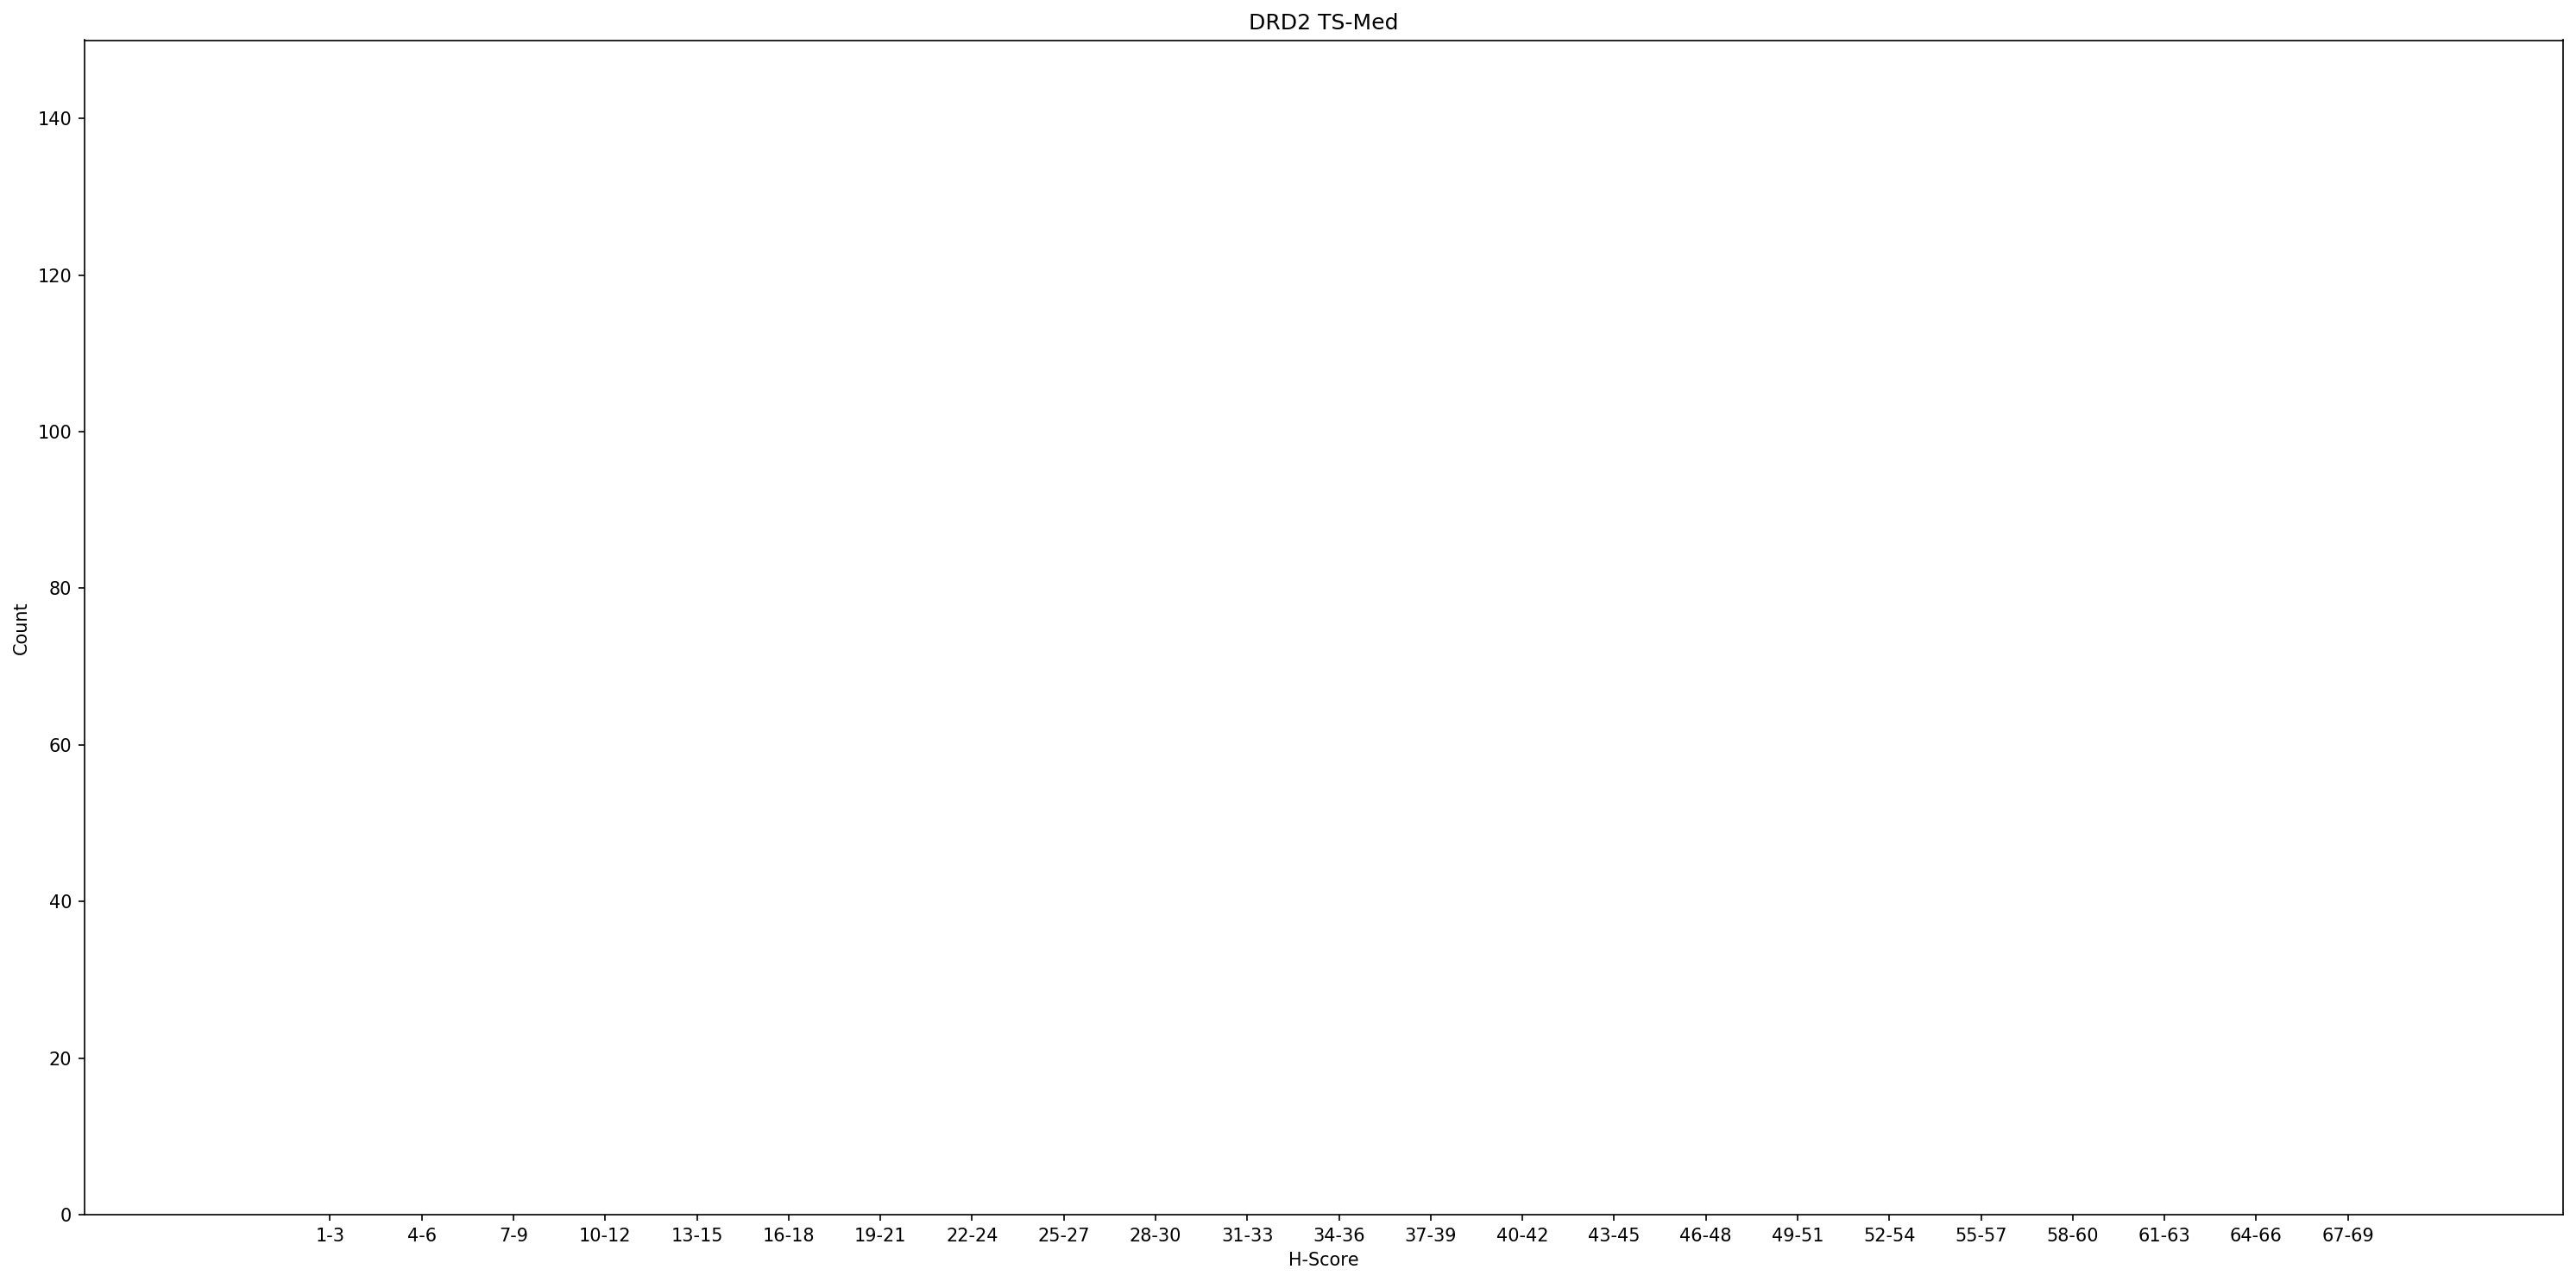

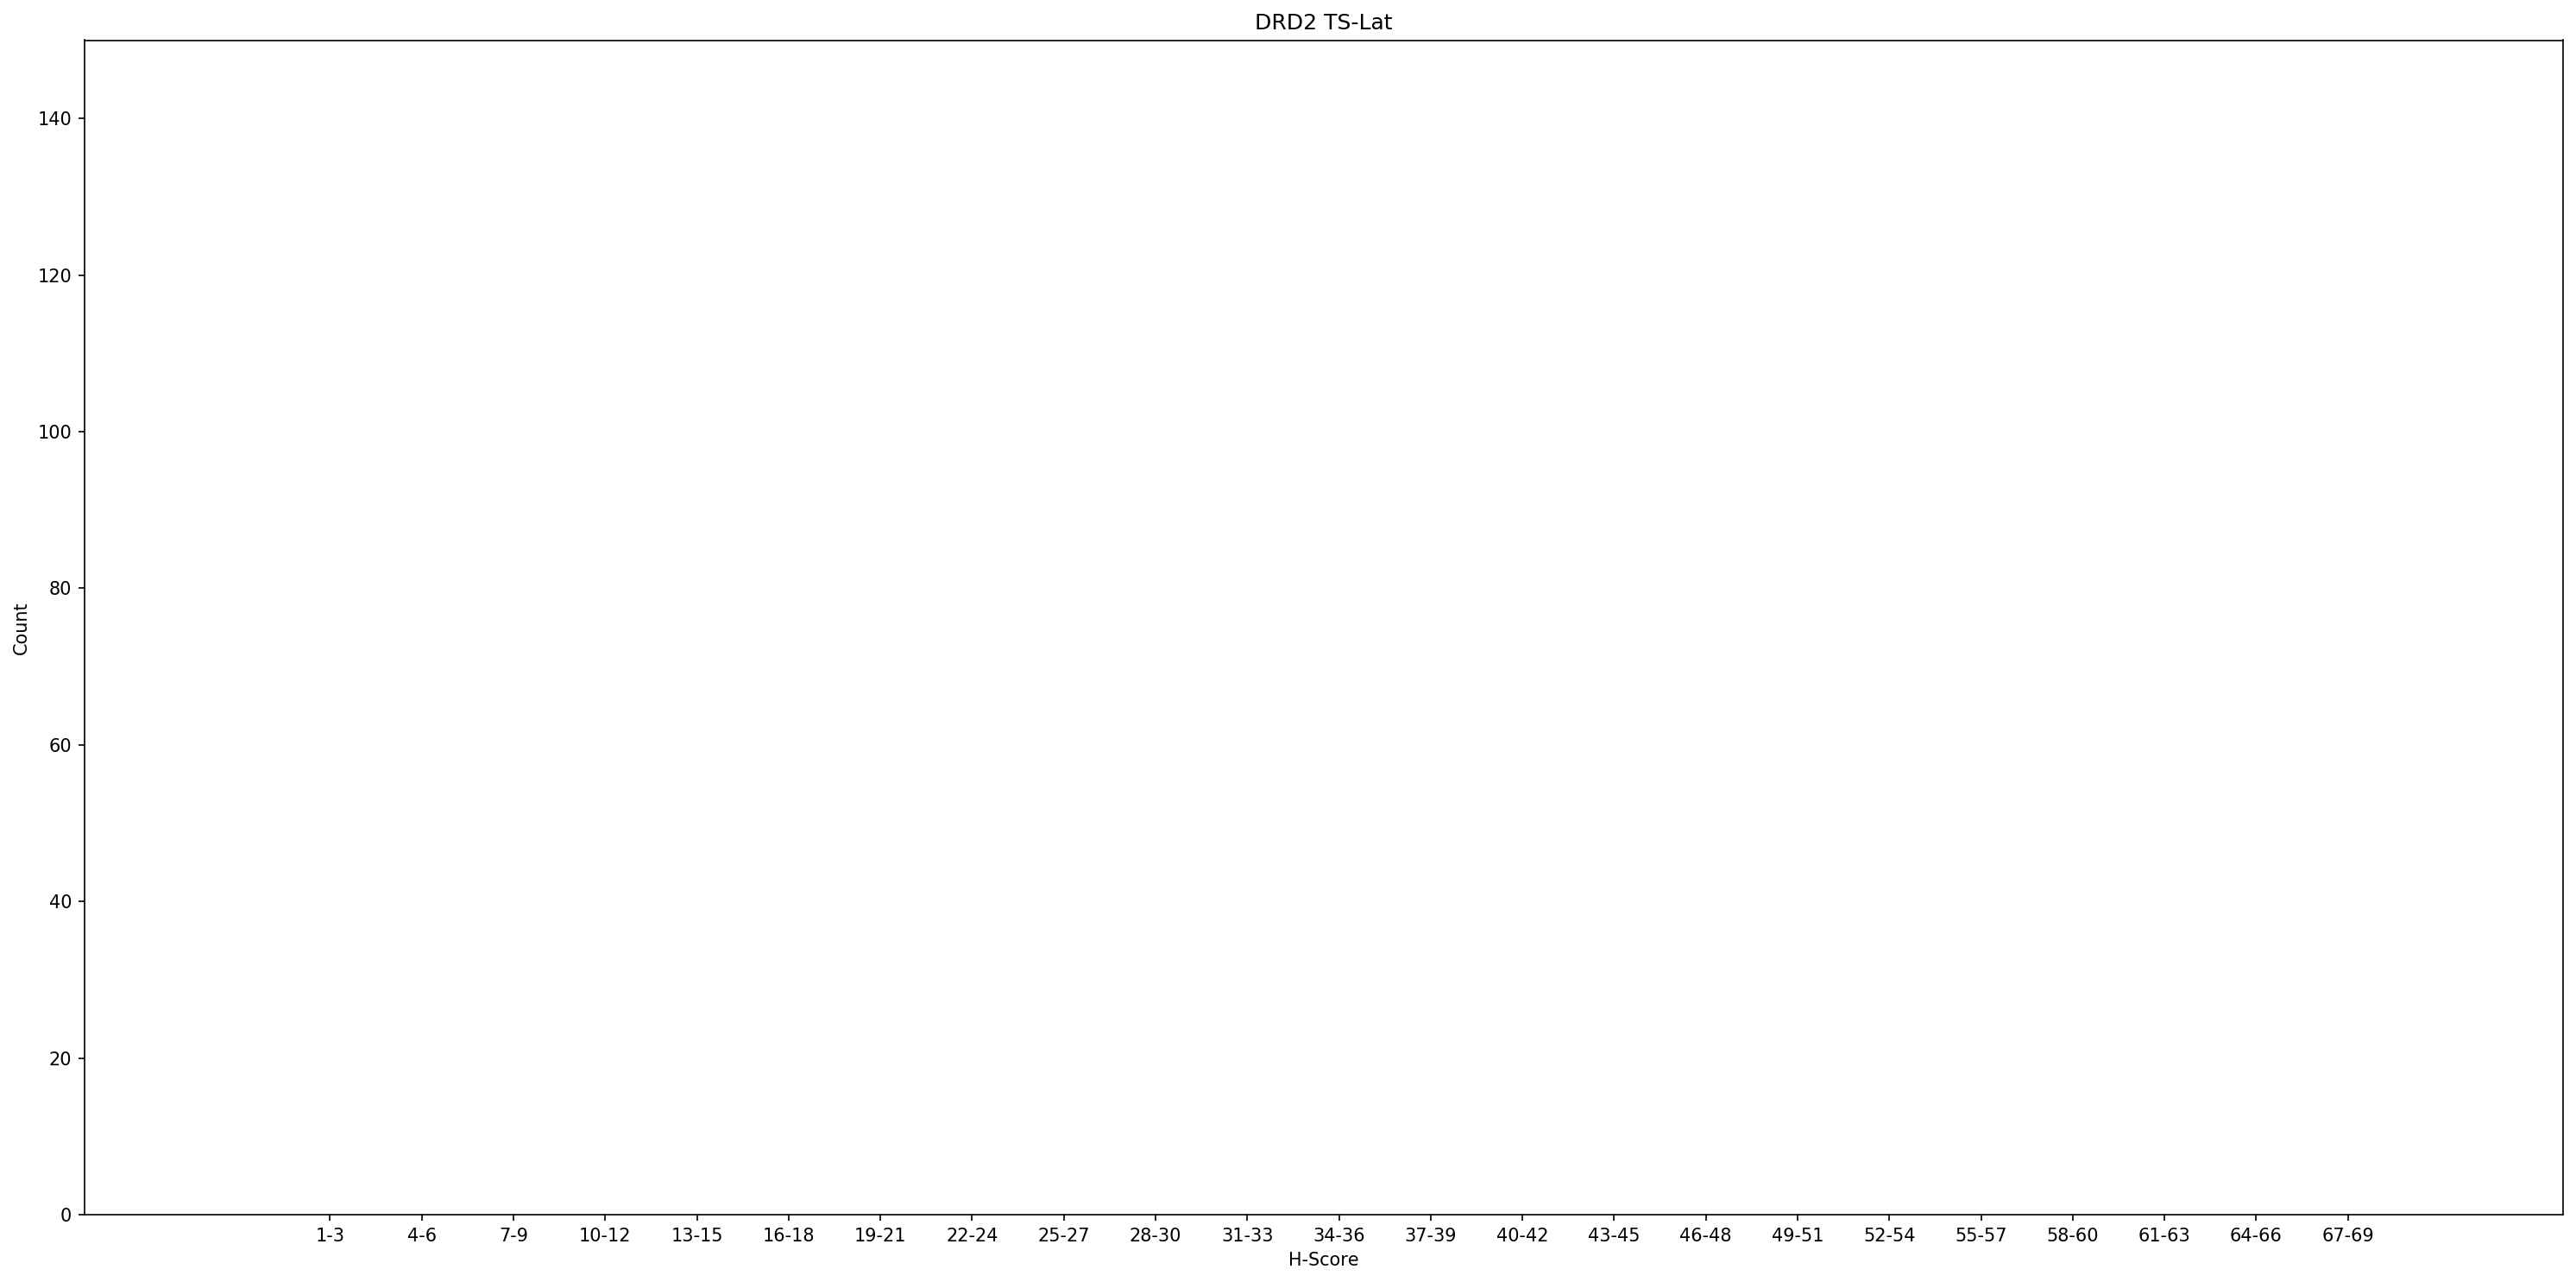

In [75]:
## Create variables for each of the sheet names in the XLSX file 
sheet_1 = 'DRD1 ASt'
sheet_2 = 'DRD1 DS'
sheet_3 = 'DRD1 TS'
sheet_4 = 'DRD1 TS-Med'
sheet_5 = 'DRD1 TS-Lat'
sheet_6 = 'DRD2 ASt'
sheet_7 = 'DRD2 DS'
sheet_8 = 'DRD2 TS'
sheet_9 = 'DRD2 TS-Med'
sheet_10 = 'DRD2 TS-Lat'

##Make 24 bar charts for each probe and AP combination
sheets = [sheet_1, sheet_2, sheet_3, sheet_4, sheet_5, 
        sheet_6, sheet_7, sheet_8, sheet_9, sheet_10] 
graph_titles = ['DRD1 ASt', 'DRD1 DS', 'DRD1 TS', 'DRD1 TS-Med', 'DRD1 TS-Lat', 
            'DRD2 ASt','DRD2 DS', 'DRD2 TS', 'DRD2 TS-Med', 'DRD2 TS-Lat']
C = ['green', 'green', 'green', 'green', 'green',
    'red', 'red', 'red', 'red', 'red']

## For each sublot, call the function to make a graph, and set graph title
for i in range(10):
    fig = plot_one_graph(sheets[i], C[i])
    plt.title(graph_titles[i])
    #plt.savefig('RNAscope H-Score Bar Charts'+ str(i) + '.jpeg', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show

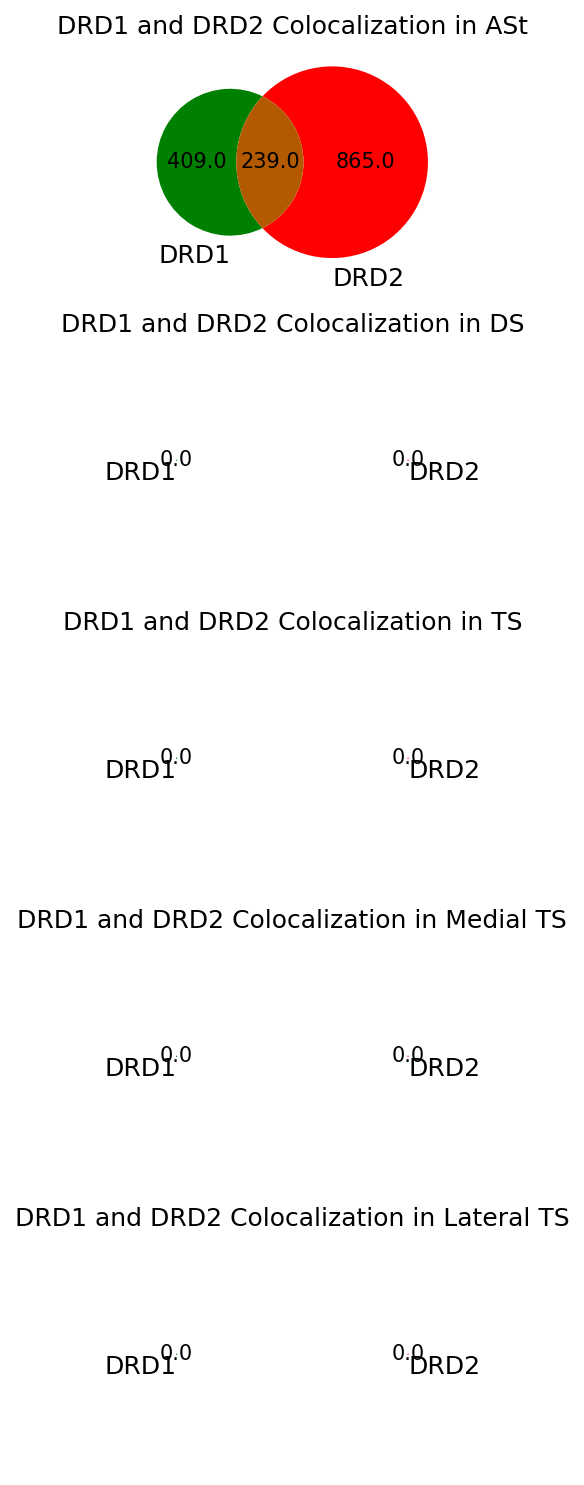

In [81]:
###import excel file
data_sheets_3 = "ASt_area_occupied_nuclei_colocalization.xlsx"

# read data from excel as pandas dataframe 
# specify which sheet to read via sheet_name = ""
data_frame = pd.read_excel(data_sheets_3, sheet_name = "Colocalization")

# find sum along rows
APsums = data_frame.iloc[0:,2:].sum(axis=1)

##DRD1 total counts
DRD1_ASt_sum = APsums[0]
DRD1_DS_sum = APsums[1]
DRD1_TS_sum = APsums[2]
DRD1_TSmed_sum = APsums[3]
DRD1_TSlat_sum = APsums[4]

##DRD2 total counts
DRD2_ASt_sum = APsums[5]
DRD2_DS_sum = APsums[6]
DRD2_TS_sum = APsums[7]
DRD2_TSmed_sum = APsums[8]
DRD2_TSlat_sum = APsums[9]


##Co-localization total counts
DRD1_DRD2_ASt_sum = APsums[10]
DRD1_DRD2_DS_sum = APsums[11]
DRD1_DRD2_TS_sum = APsums[12]
DRD1_DRD2_TSmed_sum = APsums[13]
DRD1_DRD2_TSlat_sum = APsums[14]

#make Venn diagrams with ALL DATA
fig = plt.figure(dpi=150,figsize=(10,10))
fig.add_subplot(111)

plt.subplot(5, 1, 1)
v = venn2(subsets = (DRD1_ASt_sum, DRD2_ASt_sum, DRD1_DRD2_ASt_sum), set_labels = ('DRD1','DRD2'), set_colors = ("green", "red"), alpha = 1.0)
plt.title("DRD1 and DRD2 Colocalization in ASt")
#plt.savefig('DRD1 and DRD2 Colocalization in ASt.jpeg', dpi=300, bbox_inches='tight')
plt.tight_layout()

plt.subplot(5, 1, 2)
v = venn2(subsets = (DRD1_DS_sum, DRD2_DS_sum, DRD1_DRD2_DS_sum), set_labels = ('DRD1','DRD2'), set_colors = ("green", "red"), alpha = 1.0)
plt.title("DRD1 and DRD2 Colocalization in DS")
#plt.savefig('DRD1 and DRD2 Colocalization in DS.jpeg', dpi=300, bbox_inches='tight')
plt.tight_layout()

plt.subplot(5, 1, 3)
v = venn2(subsets = (DRD1_TS_sum, DRD2_TS_sum, DRD1_DRD2_TS_sum), set_labels = ('DRD1','DRD2'), set_colors = ("green", "red"), alpha = 1.0)
plt.title("DRD1 and DRD2 Colocalization in TS")
#plt.savefig('DRD1 and DRD2 Colocalization in TS.jpeg', dpi=300, bbox_inches='tight')
plt.tight_layout()

plt.subplot(5, 1, 4)
v = venn2(subsets = (DRD1_TSmed_sum, DRD2_TSmed_sum, DRD1_DRD2_TSmed_sum), set_labels = ('DRD1','DRD2'), set_colors = ("green", "red"), alpha = 1.0)
plt.title("DRD1 and DRD2 Colocalization in Medial TS")
#plt.savefig('DRD1 and DRD2 Colocalization in Medial TS.jpeg', dpi=300, bbox_inches='tight')
plt.tight_layout()

plt.subplot(5, 1, 5)
v = venn2(subsets = (DRD1_TSlat_sum, DRD2_TSlat_sum, DRD1_DRD2_TSlat_sum), set_labels = ('DRD1','DRD2'), set_colors = ("green", "red"), alpha = 1.0)
plt.title("DRD1 and DRD2 Colocalization in Lateral TS")
#plt.savefig('DRD1 and DRD2 Colocalization in Lateral TS.jpeg', dpi=300, bbox_inches='tight')
plt.tight_layout()